# Bowling <i>et al.</i>, 2020
An Engineered CRISPR-Cas9 Mouse Line for Simultaneous Readout of Lineage Histories and Gene Expression Profiles in Single Cells

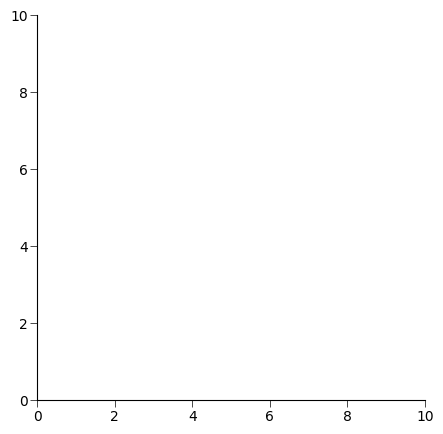

In [1]:
import scanpy as sc
import numpy as np
import operator
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import os
#setPltLinewidth(0)
# os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,6,7"

from torch.nn import DataParallel
import os
import anndata as ad
import cospar as cs
import scanpy as sc
def createFig(figsize=(8, 4)):
    fig,ax=plt.subplots()           
    ax.spines['right'].set_color('none')     
    ax.spines['top'].set_color('none')
    #ax.spines['bottom'].set_color('none')     
    #ax.spines['left'].set_color('none')
    for line in ax.yaxis.get_ticklines():
        line.set_markersize(5)
        line.set_color("#585958")
        line.set_markeredgewidth(0.5)
    for line in ax.xaxis.get_ticklines():
        line.set_markersize(5)
        line.set_markeredgewidth(0.5)
        line.set_color("#585958")
    ax.set_xbound(0,10)
    ax.set_ybound(0,10)
    fig.set_size_inches(figsize)
    return fig,ax
def setPltLinewidth(linewidth:float):
    mpl.rcParams['axes.linewidth'] = linewidth
import matplotlib as mpl
fig,ax=createFig()
fig.set_size_inches(5,5)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
setPltLinewidth(1)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 1


In [24]:
from math import sqrt

import torch
import torch.nn as nn
num_relations=3
len_geneExp=1646
len_embedding=256
learning_rate=0.000123
num_epoch=10
batchsize=512
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.LeakyReLU(inplace=False),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        #print('channel:',c)
        #print('size:',x.shape)
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        #print('y_size:',y.shape)
        return x * y.expand_as(x)
class MutiheadAttention(nn.Module):
    def __init__(self, input_dim, dim_k, dim_v,num_heads):
        super(MutiheadAttention, self).__init__()
        self.dim_q = dim_k 
        self.dim_k = dim_k
        self.dim_v = dim_v
        self.num_units=dim_k
        self.num_heads=num_heads
        self.linear_q = nn.Linear(input_dim, dim_k, bias=False)
        self.linear_k = nn.Linear(input_dim, dim_k, bias=False)
        self.linear_v = nn.Linear(input_dim, dim_v, bias=False)
        self._norm_fact = 1 / sqrt(dim_k)

    def forward(self, x):
        # x: batch_size, seq_len, input_dim
        q = self.linear_q(x)  # batch_size, seq_len, dim_k
        k = self.linear_k(x)  # batch_size, seq_len, dim_k
        v = self.linear_v(x)  # batch_size, seq_len, dim_v
        split_size = self.num_units // self.num_heads
        q = torch.stack(torch.split(q, split_size, dim=2), dim=0)  # [h, N, T_q, num_units/h]
        k = torch.stack(torch.split(k, split_size, dim=2), dim=0)  # [h, N, T_k, num_units/h]
        v = torch.stack(torch.split(v, split_size, dim=2), dim=0)  # [h, N, T_k, num_units/h]

        scores = torch.matmul(q, k.transpose(2, 3))
        scores = scores / (self.dim_k ** 0.5)
        
        scores = F.softmax(scores, dim=3)
        ## out = score * V
        out = torch.matmul(scores, v)  # [h, N, T_q, num_units/h]
        out = torch.cat(torch.split(out, 1, dim=0), dim=3).squeeze(0) 

        return out

class ResidualBlock(torch.nn.Module):
    def __init__(self,channels):
        super(ResidualBlock,self).__init__()
        self.channels = channels
        
        self.conv1 = nn.Conv1d(channels,channels,kernel_size=3,padding=1)
        self.conv2 = nn.Conv1d(channels,channels,kernel_size=3,padding=1)
        self.se=SELayer(channels,16)
    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = self.conv2(y)
        y=self.se(y)
        return F.relu(x+y)

class CNN(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.att=MutiheadAttention(len_embedding*2,512,512,64)
        self.layernorm=nn.LayerNorm(512)
        self.conv1 = nn.Conv1d(1, 32, 4)  
        self.relu1=nn.LeakyReLU(0.2, inplace=True)
        self.rblock1 = ResidualBlock(32)
        self.conv2 = nn.Conv1d(32,64, 4) 
        self.batchn1=nn.BatchNorm1d(64)
        self.relu2= nn.LeakyReLU(0.2, inplace=True)
        self.rblock2 = ResidualBlock(64)
        self.conv3=nn.Conv1d(64,128,4)
        self.batchn2=nn.BatchNorm1d(128)
        self.relu3= nn.LeakyReLU(0.2, inplace=True)
        self.rblock3 = ResidualBlock(128)
        self.conv4=nn.Conv1d(128,256,4)
        self.batchn3=nn.BatchNorm1d(256)
        self.relu4= nn.LeakyReLU(0.2, inplace=True)
        self.rblock4 = ResidualBlock(256)
        self.dropout=nn.Dropout()
        self.fc1 = nn.Linear(7424, num_relations)
        
    def forward(self, x):
        x=self.att(x)+x
        x=self.layernorm(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock1(x)
        x = self.conv2(x)
        x=self.batchn1(x)
        x=self.relu2(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock2(x)
        
        x = self.conv3(x)
        x=self.batchn2(x)
        x=self.relu3(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock3(x)
        
        x = self.conv4(x)
        x=self.batchn3(x)
        x=self.relu4(x)
        x = F.max_pool1d(x, 2)
        x=self.rblock4(x)
        x = x.view(x.size()[0], -1)
        x=self.dropout(x)
        x=self.fc1(x)
        return x
geneEnc=nn.Sequential(
    nn.Dropout(),
    nn.Linear(len_geneExp, 100),
    nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
     nn.Linear(100, 100),
            nn.ReLU(),
    nn.Linear(100, 100),
            nn.ReLU(),
    nn.Linear(100, len_embedding),
)
geneDec = nn.Sequential(
    nn.Linear(len_embedding, len_geneExp),
    #nn.Linear(512, len_geneExp),

)
genemap = nn.Sequential(
    #nn.Dropout(),
     nn.Linear(len_embedding, 100),
     nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 100),
   nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 100),
   nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, len_embedding),

)



model=CNN()
device = torch.device("cuda:6")
device2 = torch.device("cuda:6")
path='/home/zhengtuo/songtao/dynamic1.pth'
pretrained_weights = torch.load(path)
model.load_state_dict(pretrained_weights['model'])
geneEnc.load_state_dict(pretrained_weights['geneEnc'])
genemap.load_state_dict(pretrained_weights['genemap'])
geneDec.load_state_dict(pretrained_weights['geneDec'])

model.to(device2)
geneEnc.to(device2)
geneDec.to(device2)
genemap.to(device2)


genemap.eval()
model.eval()
geneEnc.eval()
geneDec.eval()


Sequential(
  (0): Linear(in_features=256, out_features=1646, bias=True)
)

In [3]:
def ScanpyVolcanoPlot(adata, axis, use_adjusted_p=True, show_label=True, label_fold_change=2, label_log_p=80, add_grid=True, label_size=4, filter_labels=None, kept_labels=None, color1='#F09D30', color2='#3D5FA6', label_excludes=None):
    fig, ax = createFig()
    names = list(map(lambda x: x[axis], adata.uns['rank_genes_groups']['names']))
    log2foldchanges = list(map(lambda x: x[axis], adata.uns['rank_genes_groups']['logfoldchanges']))
    
    if use_adjusted_p:
        log10adjp = -np.log10(list(map(lambda x: x[axis], adata.uns['rank_genes_groups']['pvals_adj'])))
    else:
        log10adjp = -np.log10(list(map(lambda x: x[axis], adata.uns['rank_genes_groups']['pvals'])))
    
    # Filter out excluded genes
    if label_excludes is not None:
        include_indices = [i for i, name in enumerate(names) if name not in label_excludes]
        log2foldchanges = [log2foldchanges[i] for i in include_indices]
        log10adjp = [log10adjp[i] for i in include_indices]
        names = [names[i] for i in include_indices]
    
    ax.scatter(
        x=log2foldchanges,
        y=log10adjp,
        s=12,
        alpha=0.8,
        linewidth=0,
        c=list(map(lambda x: color2 if abs(x[0]) > label_fold_change and x[1] > label_log_p and x[0] < 0
                   else color1 if abs(x[0]) > label_fold_change and x[1] > label_log_p and x[0] > 0
                   else 'gray', zip(log2foldchanges, log10adjp)))
    )
    
    if add_grid:
        ax.axvline(-label_fold_change, color ="black", alpha = 0.8, lw = 0.8, ls='--')
        ax.axvline(label_fold_change, color ="black", alpha = 0.8, lw = 0.8, ls='--')
        ax.axhline(label_log_p, color ="black", alpha = 0.8, lw = 0.8, ls='--')
        ax.grid(alpha=0.4)
    if show_label:
        indices = list(map(lambda x: abs(x[0]) > label_fold_change and x[1] > label_log_p, zip(log2foldchanges, log10adjp)))
        for i, j, s in zip(np.array(log2foldchanges)[indices], np.array(log10adjp)[indices], np.array(names)[indices]):
            if label_excludes is not None and s in label_excludes:
                continue
            if filter_labels is not None and s in filter_labels:
                continue
            if kept_labels is not None and s not in kept_labels:
                continue
            ax.text(i, j, s=s, size=label_size)
    
    return fig, ax

In [34]:

adata=cs.hf.read('/home/zhengtuo/songtao/9.20_carlin_withprob.h5ad')


In [35]:
adata.obs['preference_HSC'].value_counts()

Ery    207
My     179
Name: preference_HSC, dtype: int64

In [32]:
#bowling_adata_=cs.hf.read("/home/zhengtuo/songtao/dynamic.h5ad")


In [37]:

dic1={'Mo':'My','Neu':'My','Mk':'Ery','HSC':'HSC'}
adata.obs['reannotation']=adata.obs['reannotation'].map(dic1)
adata.obs['reannotation'].unique()

array(['Ery', 'HSC', 'My'], dtype=object)

/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


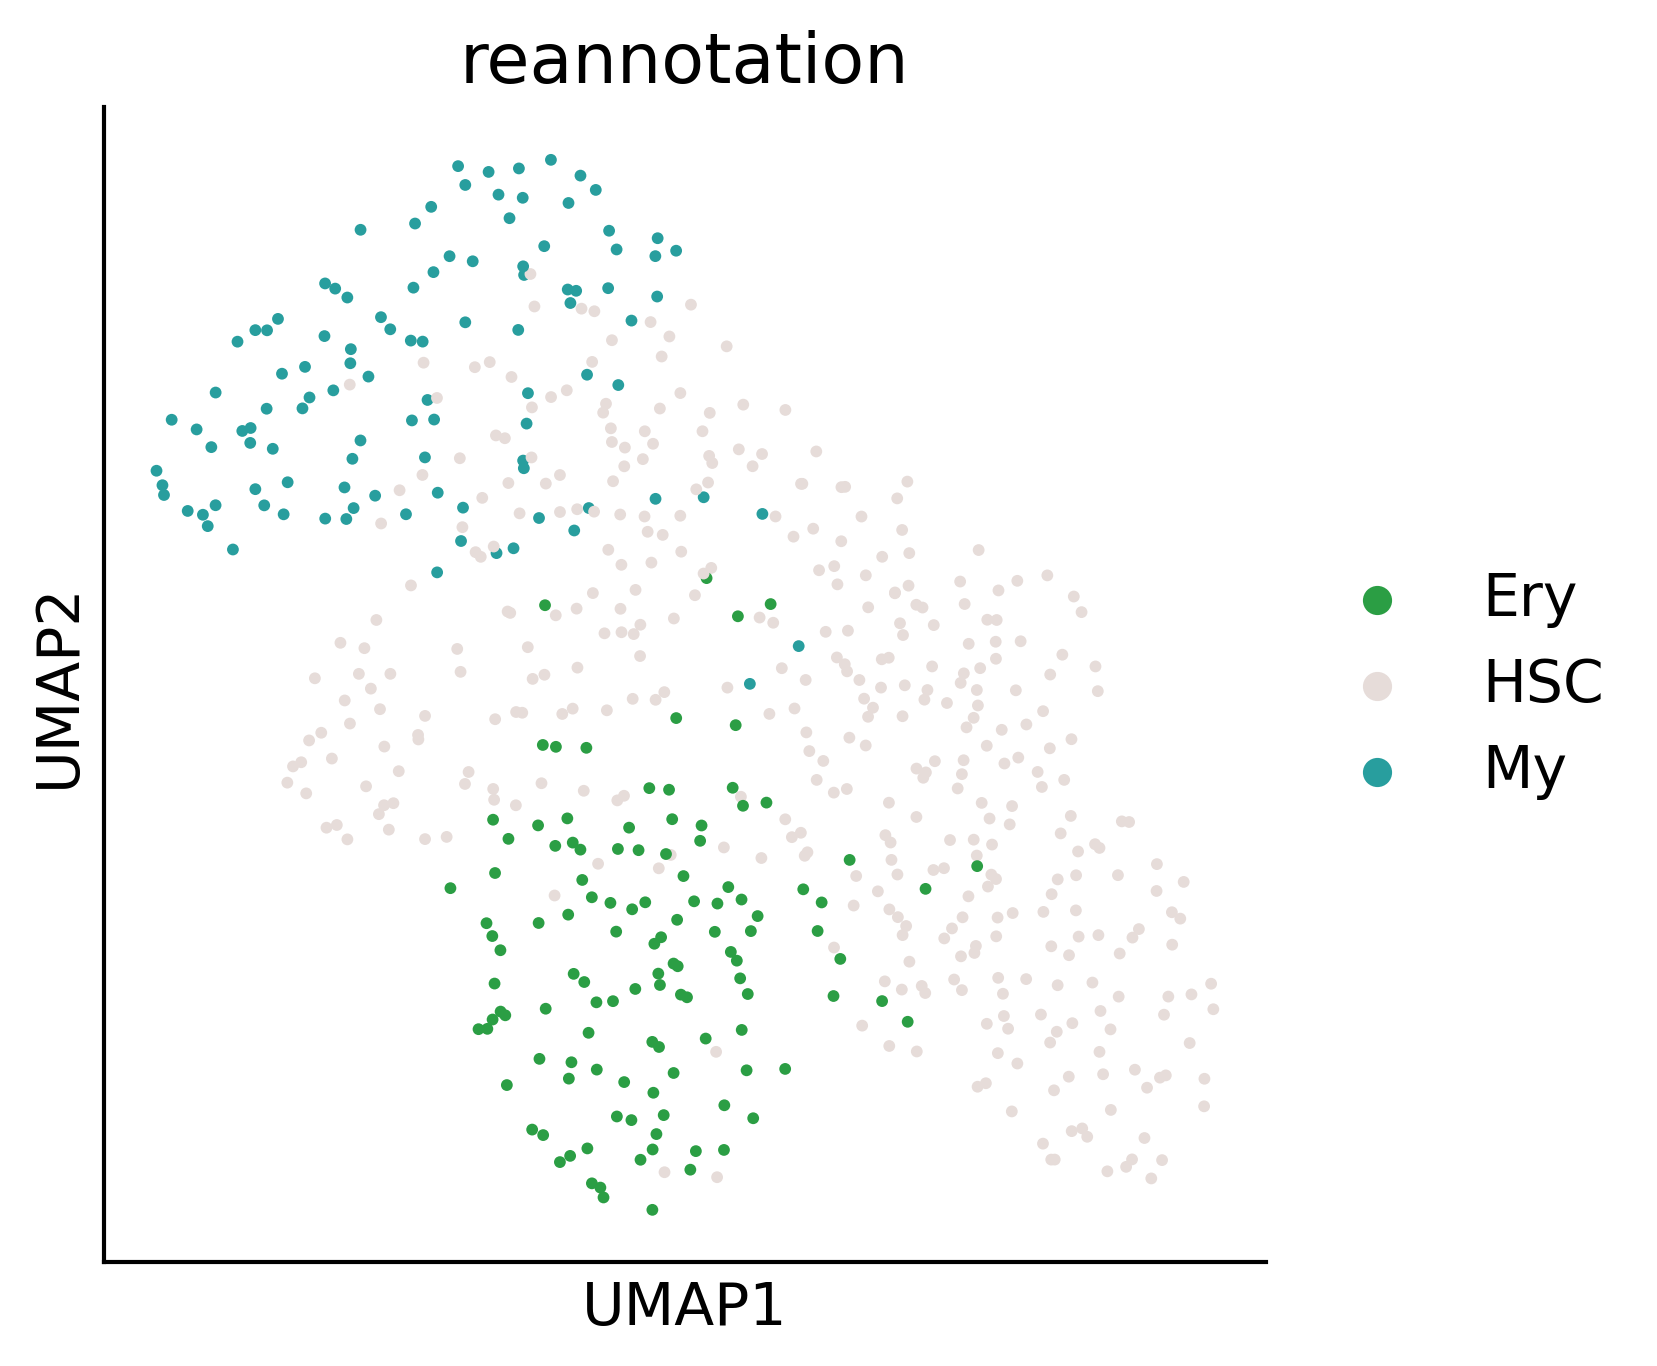

In [38]:
fig,ax=createFig((5,5))
sc.pl.umap(adata, color='reannotation', palette = {
    "Ery": "#2B9E44",
    "My": "#289E9E",
    "HSC": '#E6DCD9'
}, s=32, ax=ax)


/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


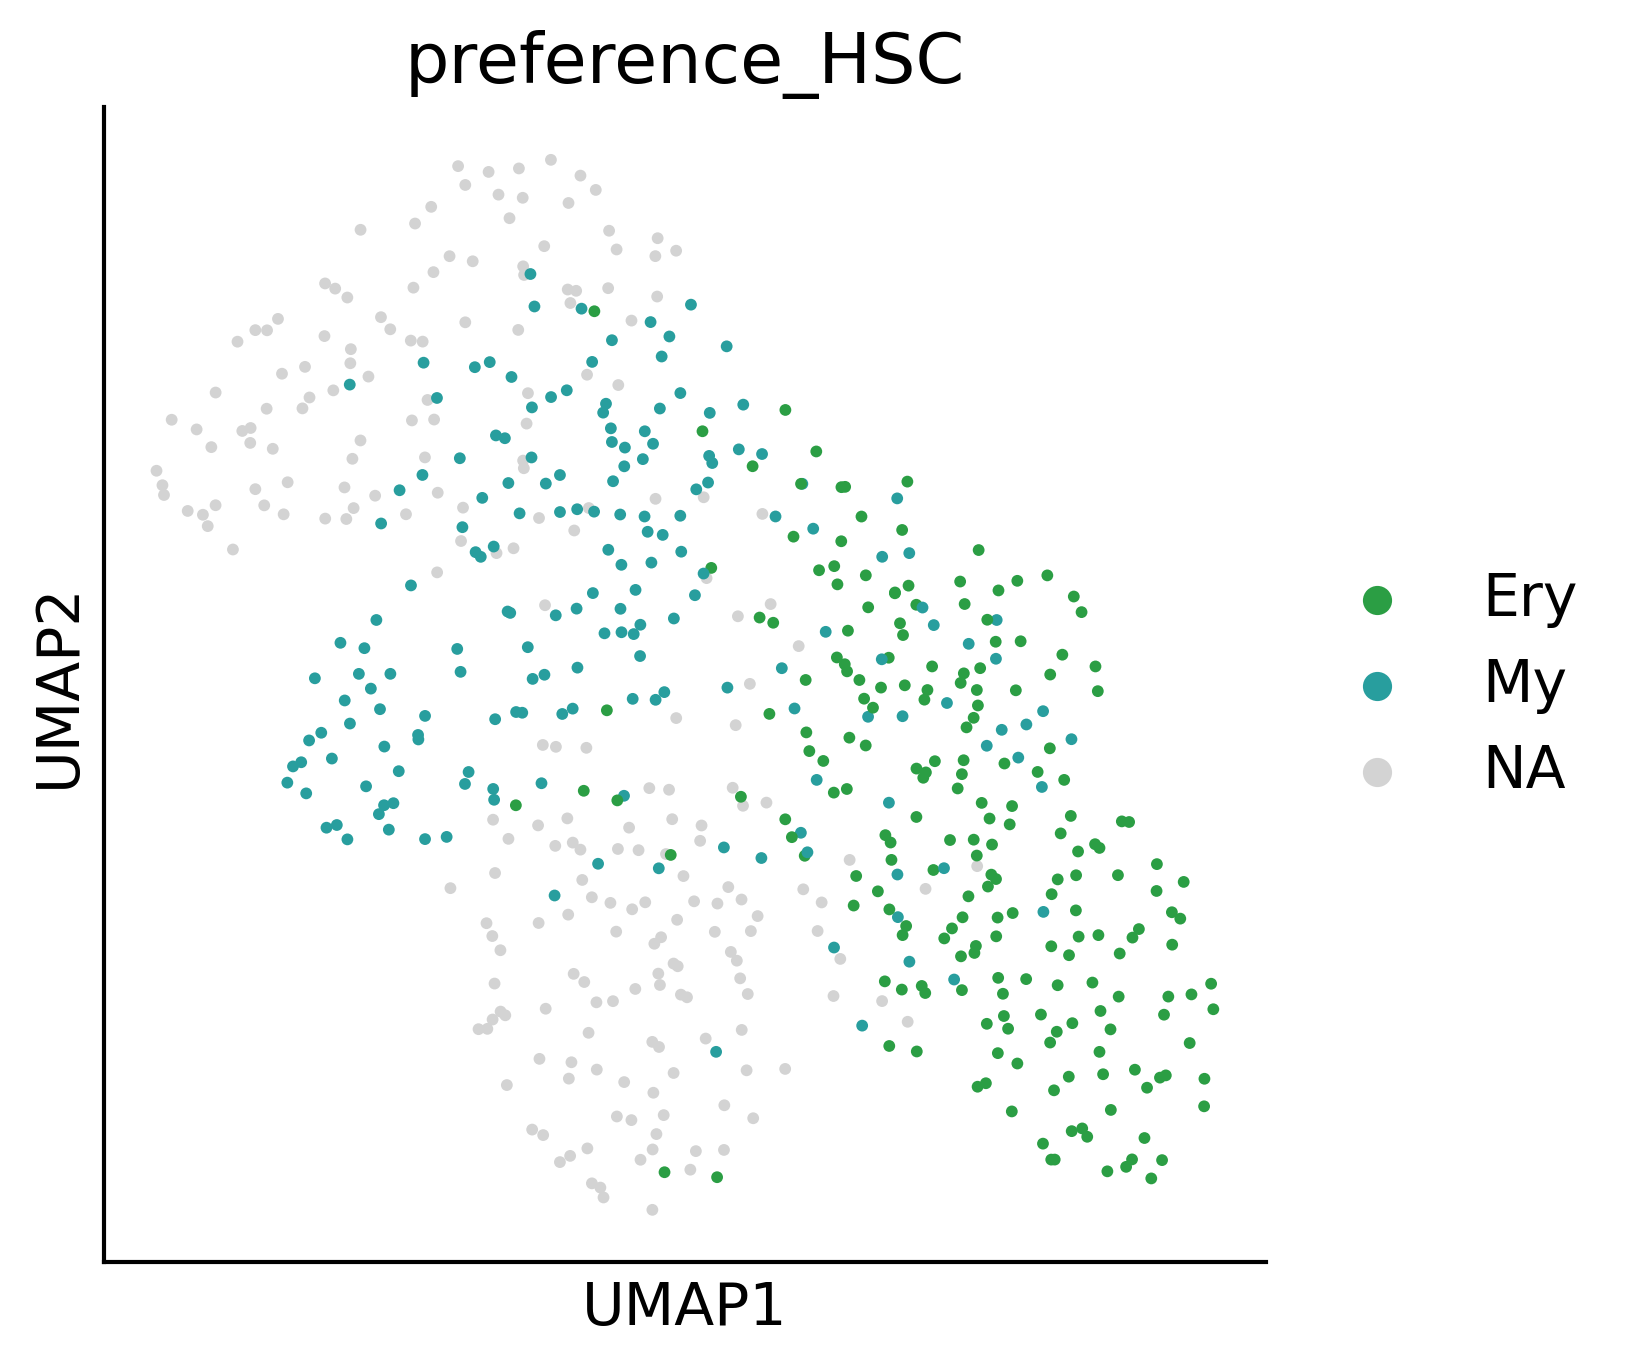

In [39]:
fig,ax=createFig((5,5))
sc.pl.umap(adata, color='preference_HSC', palette = {
    "Ery": "#2B9E44",
    "My": "#289E9E",
    "HSC": '#E6DCD9'
}, s=32, ax=ax)


In [418]:
import sklearn
sklearn.metrics.silhouette_score(
    adata[adata.obs['preference_HSC'].isin(['My','Ery'])].obsm["X_umap"],
    adata[adata.obs['preference_HSC'].isin(['My','Ery'])].obs['preference_HSC']
)

0.3386568

/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


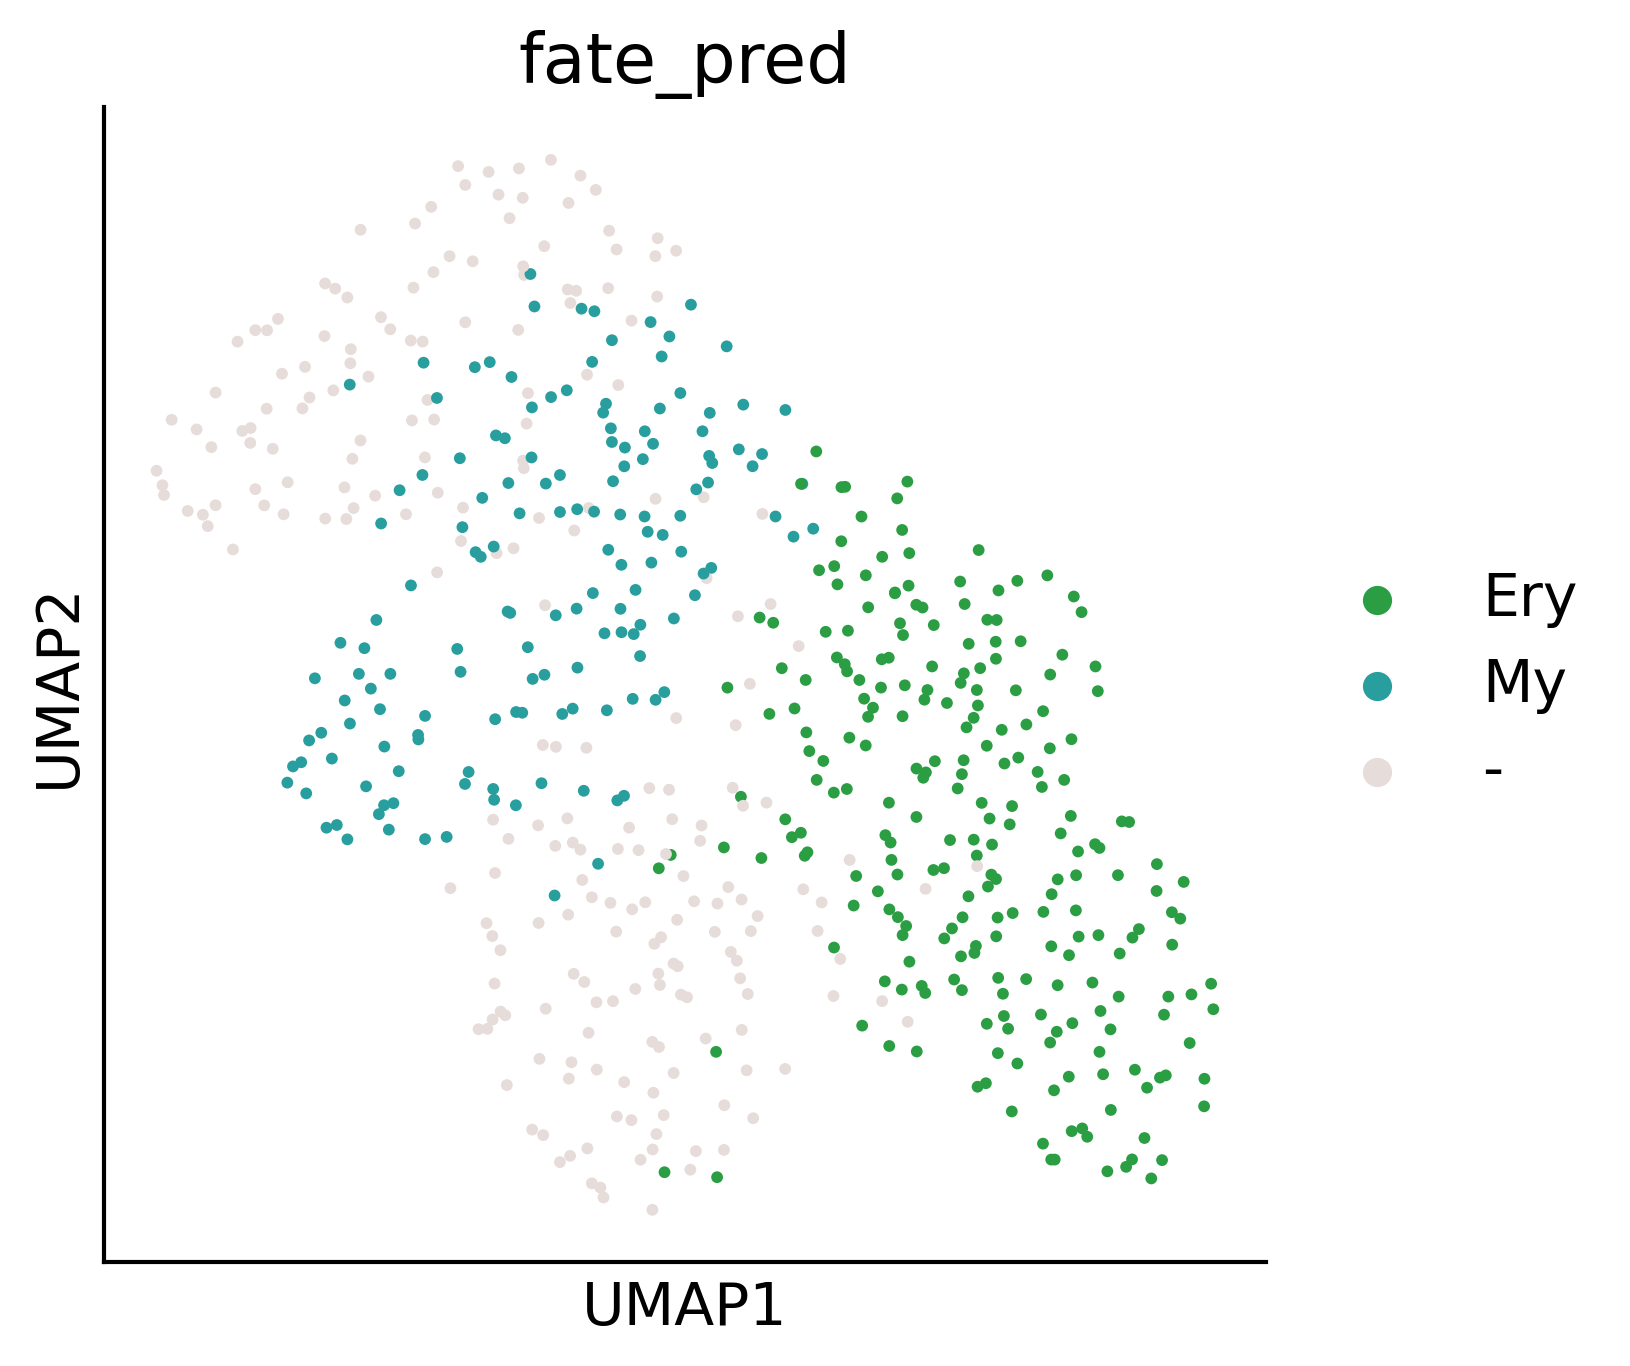

In [478]:
fig,ax=createFig((5,5))
sc.pl.umap(adata, color='fate_pred', palette = {
    "Ery": "#2B9E44",
    "My": "#289E9E",
    "HSC": '#E6DCD9',
    "-": '#E6DCD9',
}, s=32, ax=ax)
ax.figure.savefig('/home/zhengtuo/songtao/DestinyNet/carlin_figure/carlin_fate_pred.pdf', bbox_inches='tight') 


In [419]:
def compute_velocity_on_grid(
    X_emb,
    M_emb,
    density=None,
    smooth=None,
    n_neighbors=None,
    min_mass=None,
    autoscale=True,
    adjust_for_stream=False,
    cutoff_perc=None,
):
    # remove invalid cells
    idx_valid = np.isfinite(X_emb.sum(1) + M_emb.sum(1))
    X_emb = X_emb[idx_valid]
    M_emb = M_emb[idx_valid]

    # prepare grid
    n_obs, n_dim = X_emb.shape
    density = 0.5 if density is None else density
    smooth = 0.5 if smooth is None else smooth

    grs = []
    for dim_i in range(n_dim):
        m, M = np.min(X_emb[:, dim_i]), np.max(X_emb[:, dim_i])
        m = m - 0.01 * np.abs(M - m)
        M = M + 0.01 * np.abs(M - m)
        gr = np.linspace(m, M, int(50 * density))
        grs.append(gr)

    meshes_tuple = np.meshgrid(*grs)
    X_grid = np.vstack([i.flat for i in meshes_tuple]).T

    # estimate grid velocities
    if n_neighbors is None:
        n_neighbors = int(n_obs / 50)
    nn = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1)
    nn.fit(X_emb)
    dists, neighs = nn.kneighbors(X_grid)

    scale = np.mean([(g[1] - g[0]) for g in grs]) * smooth
    weight = normal.pdf(x=dists, scale=scale)
    p_mass = weight.sum(1)

    V_grid = (M_emb[neighs] * weight[:, :, None]).sum(1)
    V_grid /= np.maximum(1, p_mass)[:, None]
    if min_mass is None:
        min_mass = 1

    if adjust_for_stream:
        X_grid = np.stack([np.unique(X_grid[:, 0]), np.unique(X_grid[:, 1])])
        ns = int(np.sqrt(len(V_grid[:, 0])))
        V_grid = V_grid.T.reshape(2, ns, ns)

        mass = np.sqrt((V_grid ** 2).sum(0))
        min_mass = 10 ** (min_mass - 6)  # default min_mass = 1e-5
        min_mass = np.clip(min_mass, None, np.max(mass) * 0.9)
        cutoff = mass.reshape(V_grid[0].shape) < min_mass

        if cutoff_perc is None:
            cutoff_perc = 5
        length = np.sum(np.mean(np.abs(M_emb[neighs]), axis=1), axis=1).T
        length = length.reshape(ns, ns)
        cutoff |= length < np.percentile(length, cutoff_perc)

        V_grid[0][cutoff] = np.nan
    else:
        min_mass *= np.percentile(p_mass, 99) / 100
        X_grid, V_grid = X_grid[p_mass > min_mass], V_grid[p_mass > min_mass]

        if autoscale:
            V_grid /= 3 * quiver_autoscale(X_grid, V_grid)

    return X_grid, V_grid

def quiver_autoscale(X_emb, V_emb):
    import matplotlib.pyplot as pl

    scale_factor = np.abs(X_emb).max()  # just so that it handles very large values
    fig, ax = pl.subplots()
    Q = ax.quiver(
        X_emb[:, 0] / scale_factor,
        X_emb[:, 1] / scale_factor,
        V_emb[:, 0],
        V_emb[:, 1],
        angles="xy",
        scale_units="xy",
        scale=None,
    )
    Q._init()
    fig.clf()
    pl.close(fig)
    return Q.scale / scale_factor


100%|███████████████████████████████████████| 612/612 [00:00<00:00, 1271.66it/s]


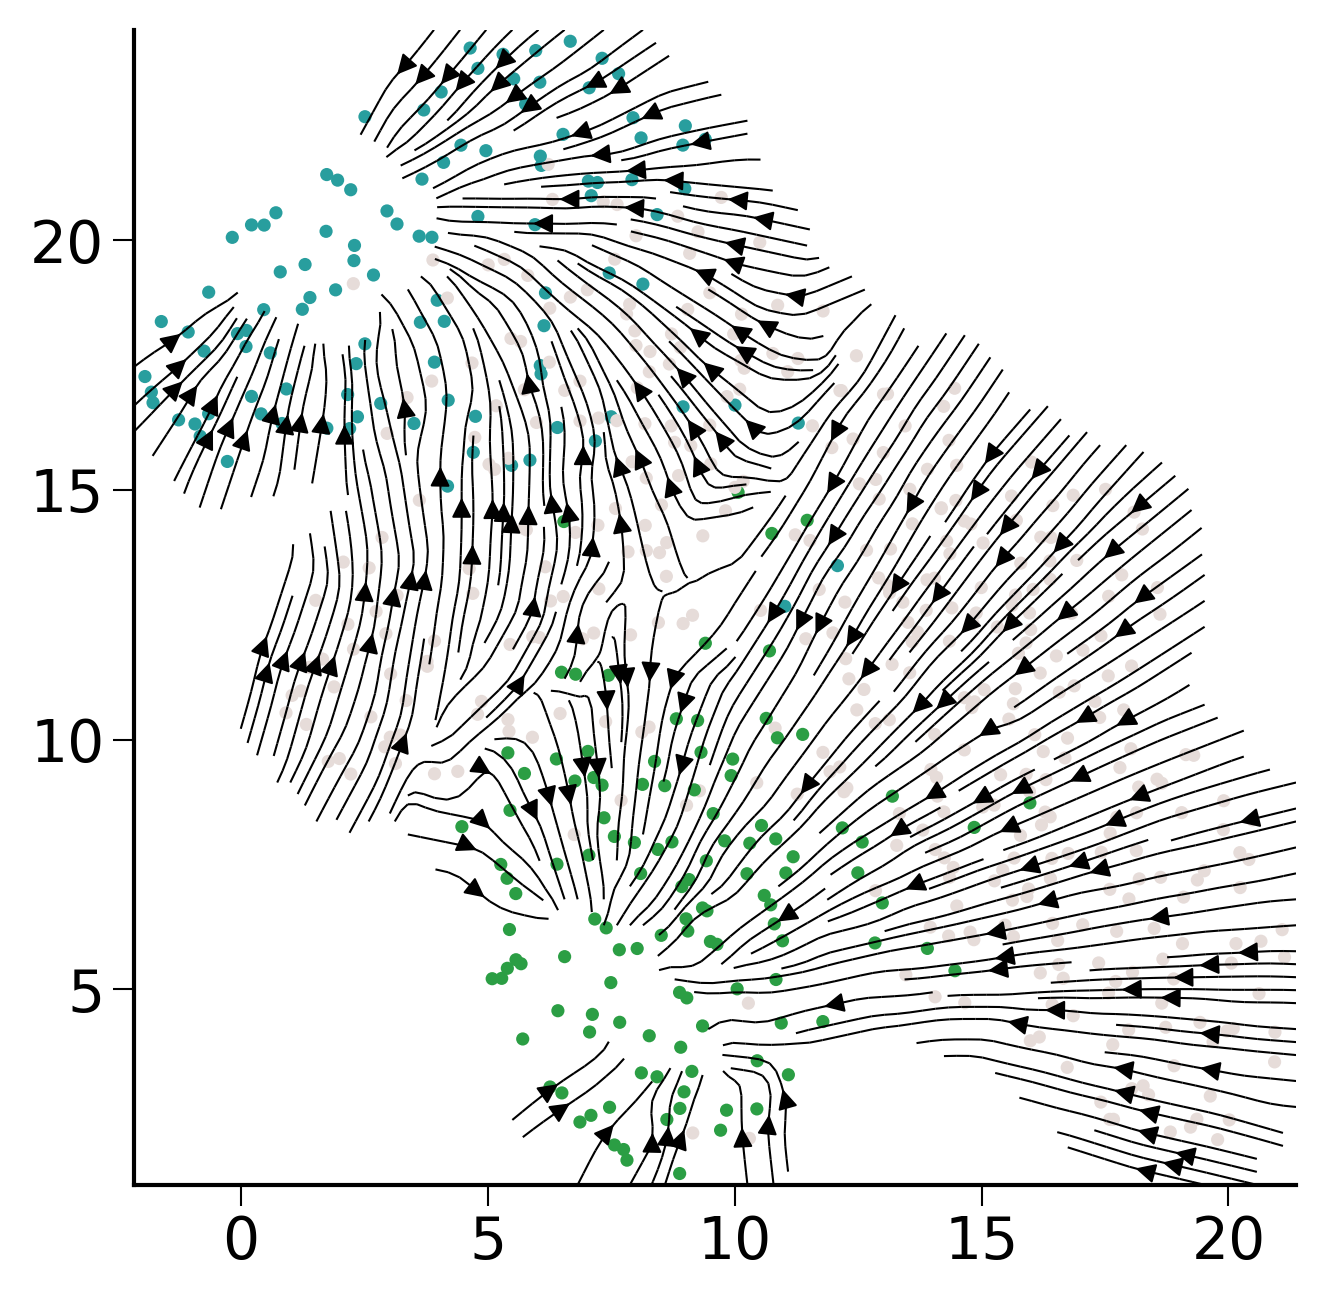

In [420]:
import numpy as np
from scipy.stats import norm as normal
from sklearn.neighbors import NearestNeighbors
import tqdm
adata2=adata


sc.pp.neighbors(adata)

X = adata.obsm['geneEnc'][:,0,:]
M = adata.obsm['genemap'][:,0,:]
N = adata.obsp['connectivities']
E = adata.obsm["X_umap"]
norm = lambda x: (x-min(x))/(max(x)-min(x))
nn = NearestNeighbors(n_neighbors=5)
nn.fit(X)
dE = []
for i in tqdm.trange(N.shape[0]):

    D,I = nn.kneighbors( np.array([M[i]]) )
    dE.append( (E[I][0] - E[i]).mean(0))
dE = np.vstack(dE)
gE, gdE = compute_velocity_on_grid(E,dE,density=2, adjust_for_stream=True,smooth=True)
fig,ax=createFig()
fig.set_size_inches(5,5)
palette = sc.pl._tools.scatterplots._get_palette(adata, 'reannotation')
ax.scatter(E[:,0],E[:,1],s=10, linewidths=0,c=list(map(lambda x: palette[x], adata.obs['reannotation'])))
stream_kwargs = {
        "linewidth": 0.5,
        "density": 3,
        "zorder": 3,
        "color": "black",
        "arrowsize":  1,
    
        "arrowstyle": "-|>",
        "maxlength":  10,
        "integration_direction":  "both",
}
ax.streamplot(gE[0],gE[1],gdE[0],gdE[1],**stream_kwargs)


/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


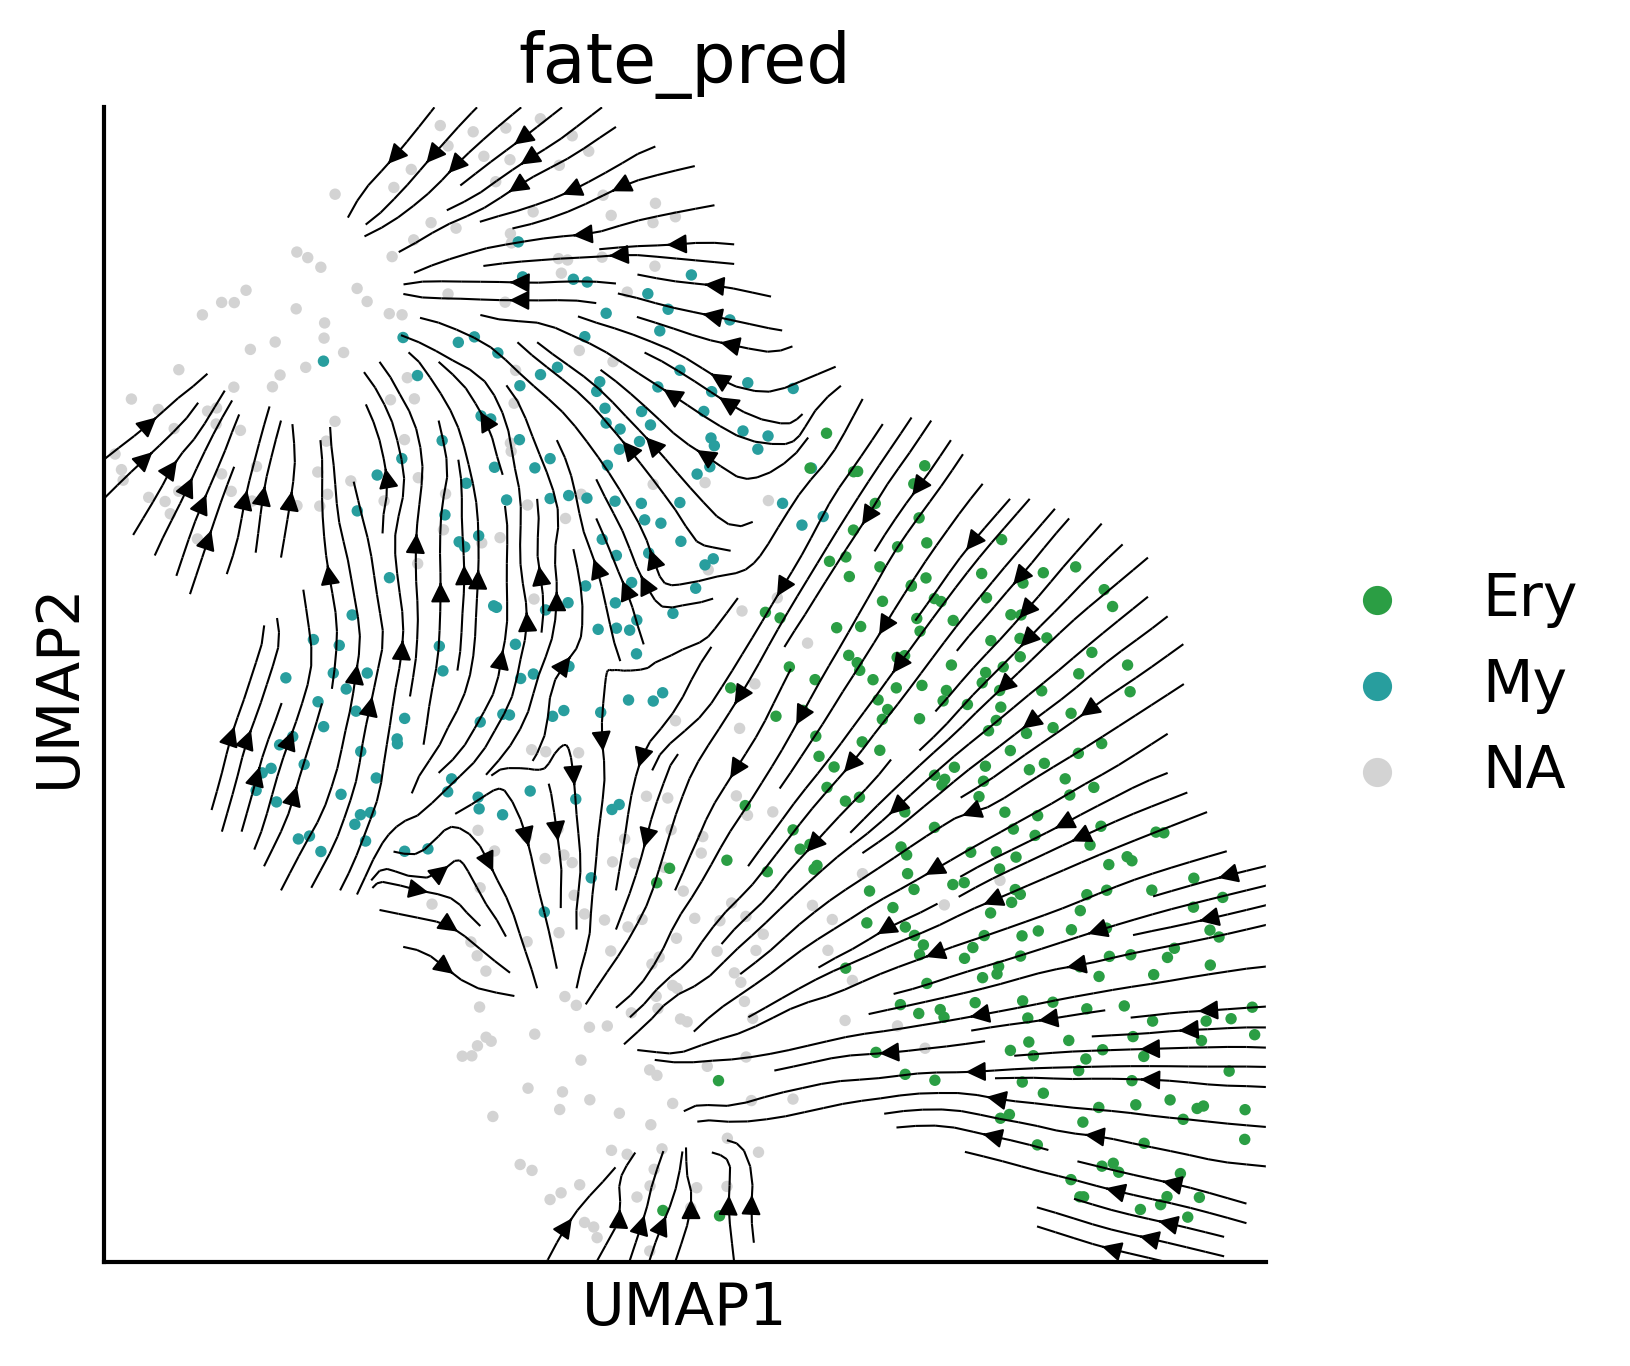

In [423]:

fig,ax=createFig(figsize=(5, 5))
fig.set_size_inches(5,5)
palette = sc.pl._tools.scatterplots._get_palette(adata, 'fate_pred')
ax.scatter(
    adata[adata.obs['preference_HSC'] == 'HSC'].obsm["X_umap"][:,0],
    adata[adata.obs['preference_HSC'] == 'HSC'].obsm["X_umap"][:,1],
    s = 2, color='#E6DCD9', linewidth=0
)
sc.pl.umap(
    adata[adata.obs['preference_HSC'] != 'HSC'], 
    ax=ax, 
    color='fate_pred', 
    s=30, 
    palette = {
    "Ery": "#2B9E44",
    "My": "#289E9E",
    "HSC": '#E6DCD9'
},
    show=False
)
stream_kwargs = {
        "linewidth": 0.5,
        "density": 2,
        "zorder": 3,
        "color": "black",
        "arrowsize":  1,
    
        "arrowstyle": "-|>",
        "maxlength":  10,
        "integration_direction":  "both",
}

ax.streamplot(gE[0],gE[1],gdE[0],gdE[1],**stream_kwargs)
plt.savefig("/home/zhengtuo/songtao/DestinyNet/carlin_figure/flow.pdf")

/tmp/ipykernel_97488/2133507794.py:2: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  adata.obs['fate_pred'].cat.add_categories(['-'], inplace=True)
/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


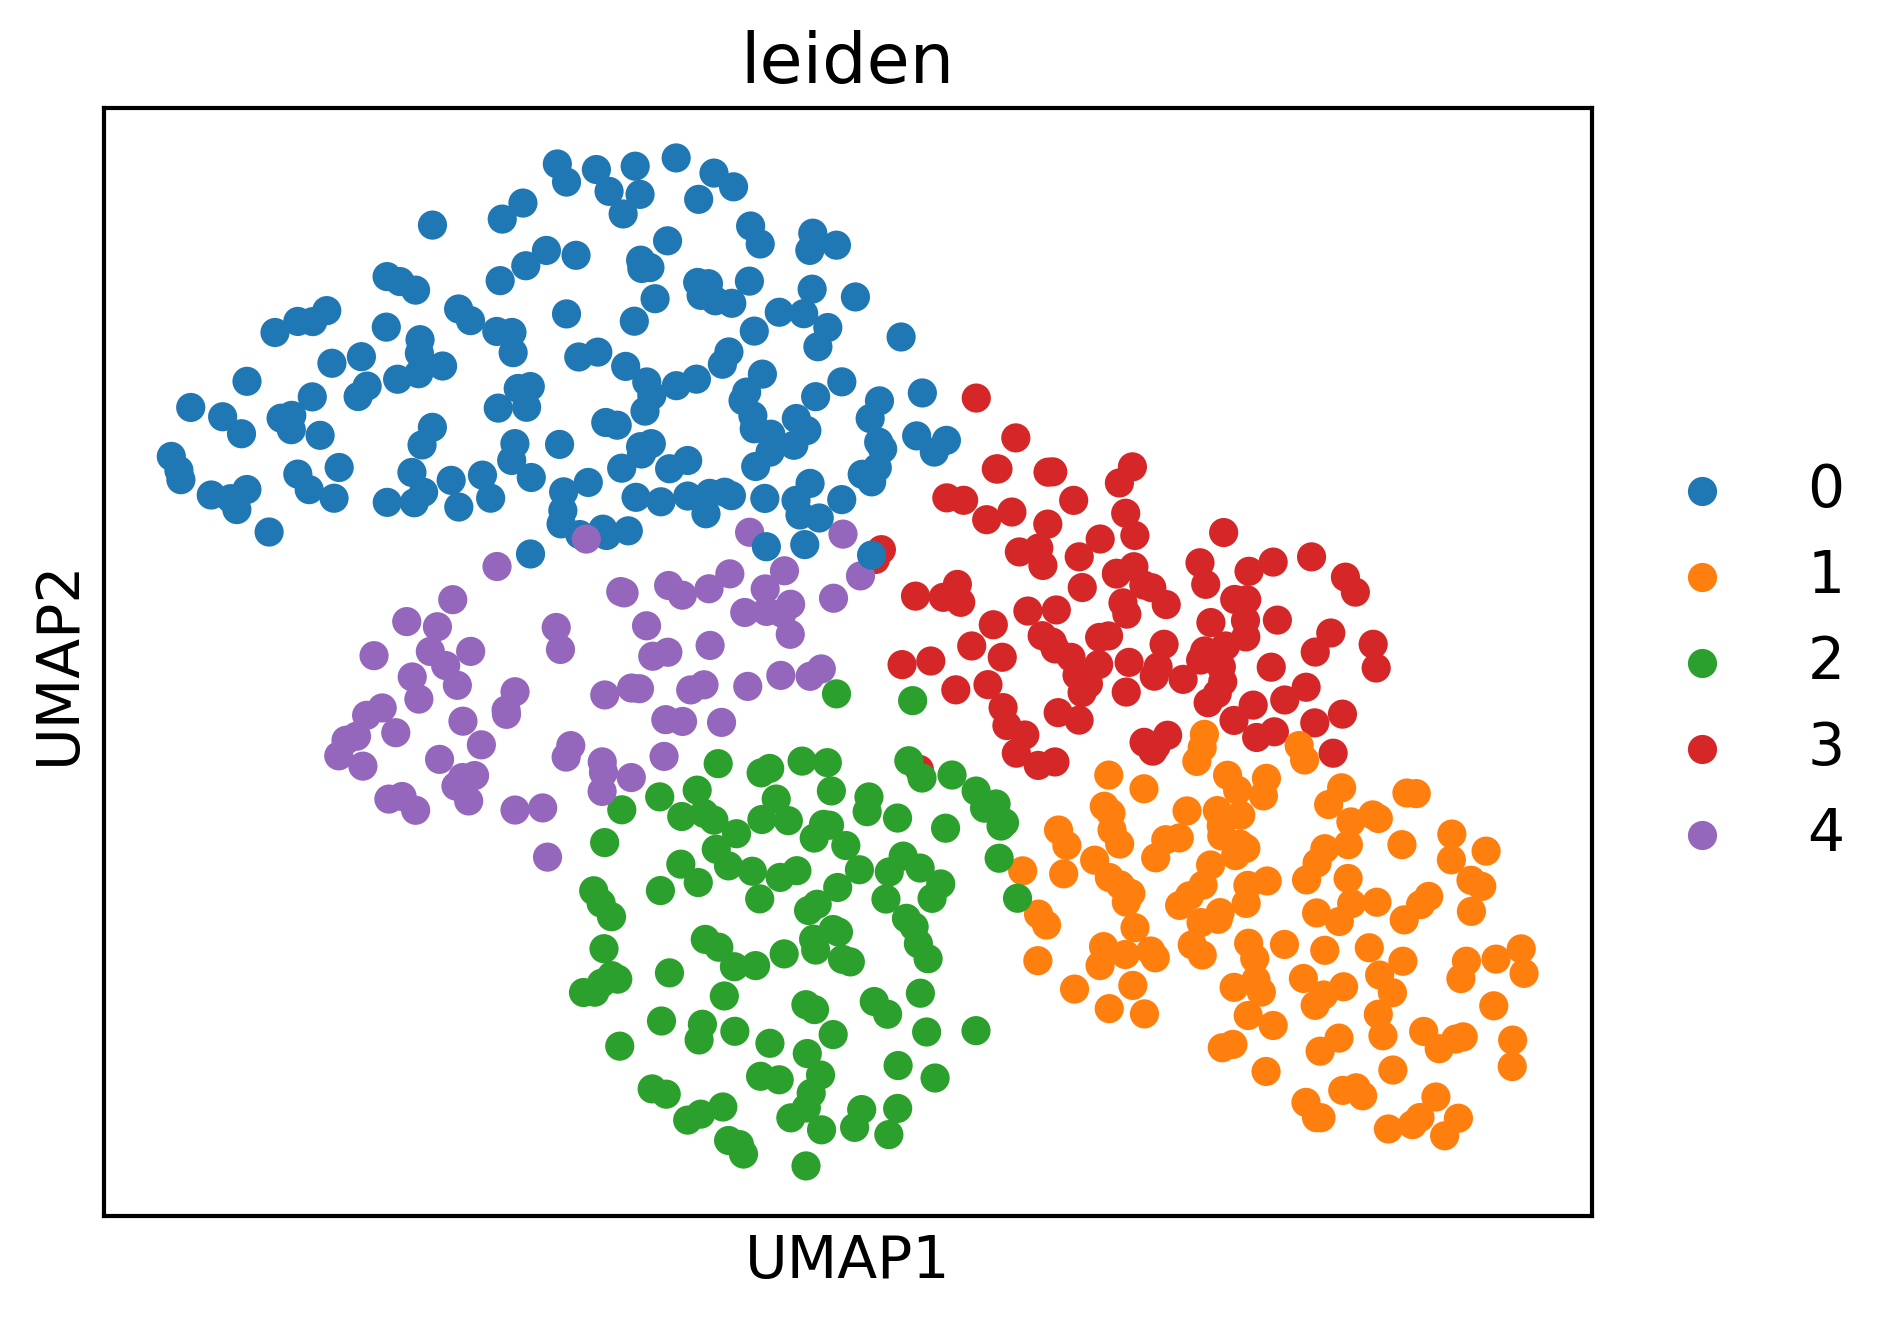

In [424]:
sc.tl.leiden(adata, resolution=0.3)
adata.obs['fate_pred'].cat.add_categories(['-'], inplace=True)

adata.obs['fate_pred'] = adata.obs['fate_pred'].fillna('-')
sc.pl.umap(adata,color='leiden')


In [426]:
adata.obs['fate_pred'].value_counts()

Ery    236
-      226
My     150
Name: fate_pred, dtype: int64

<Axes: >

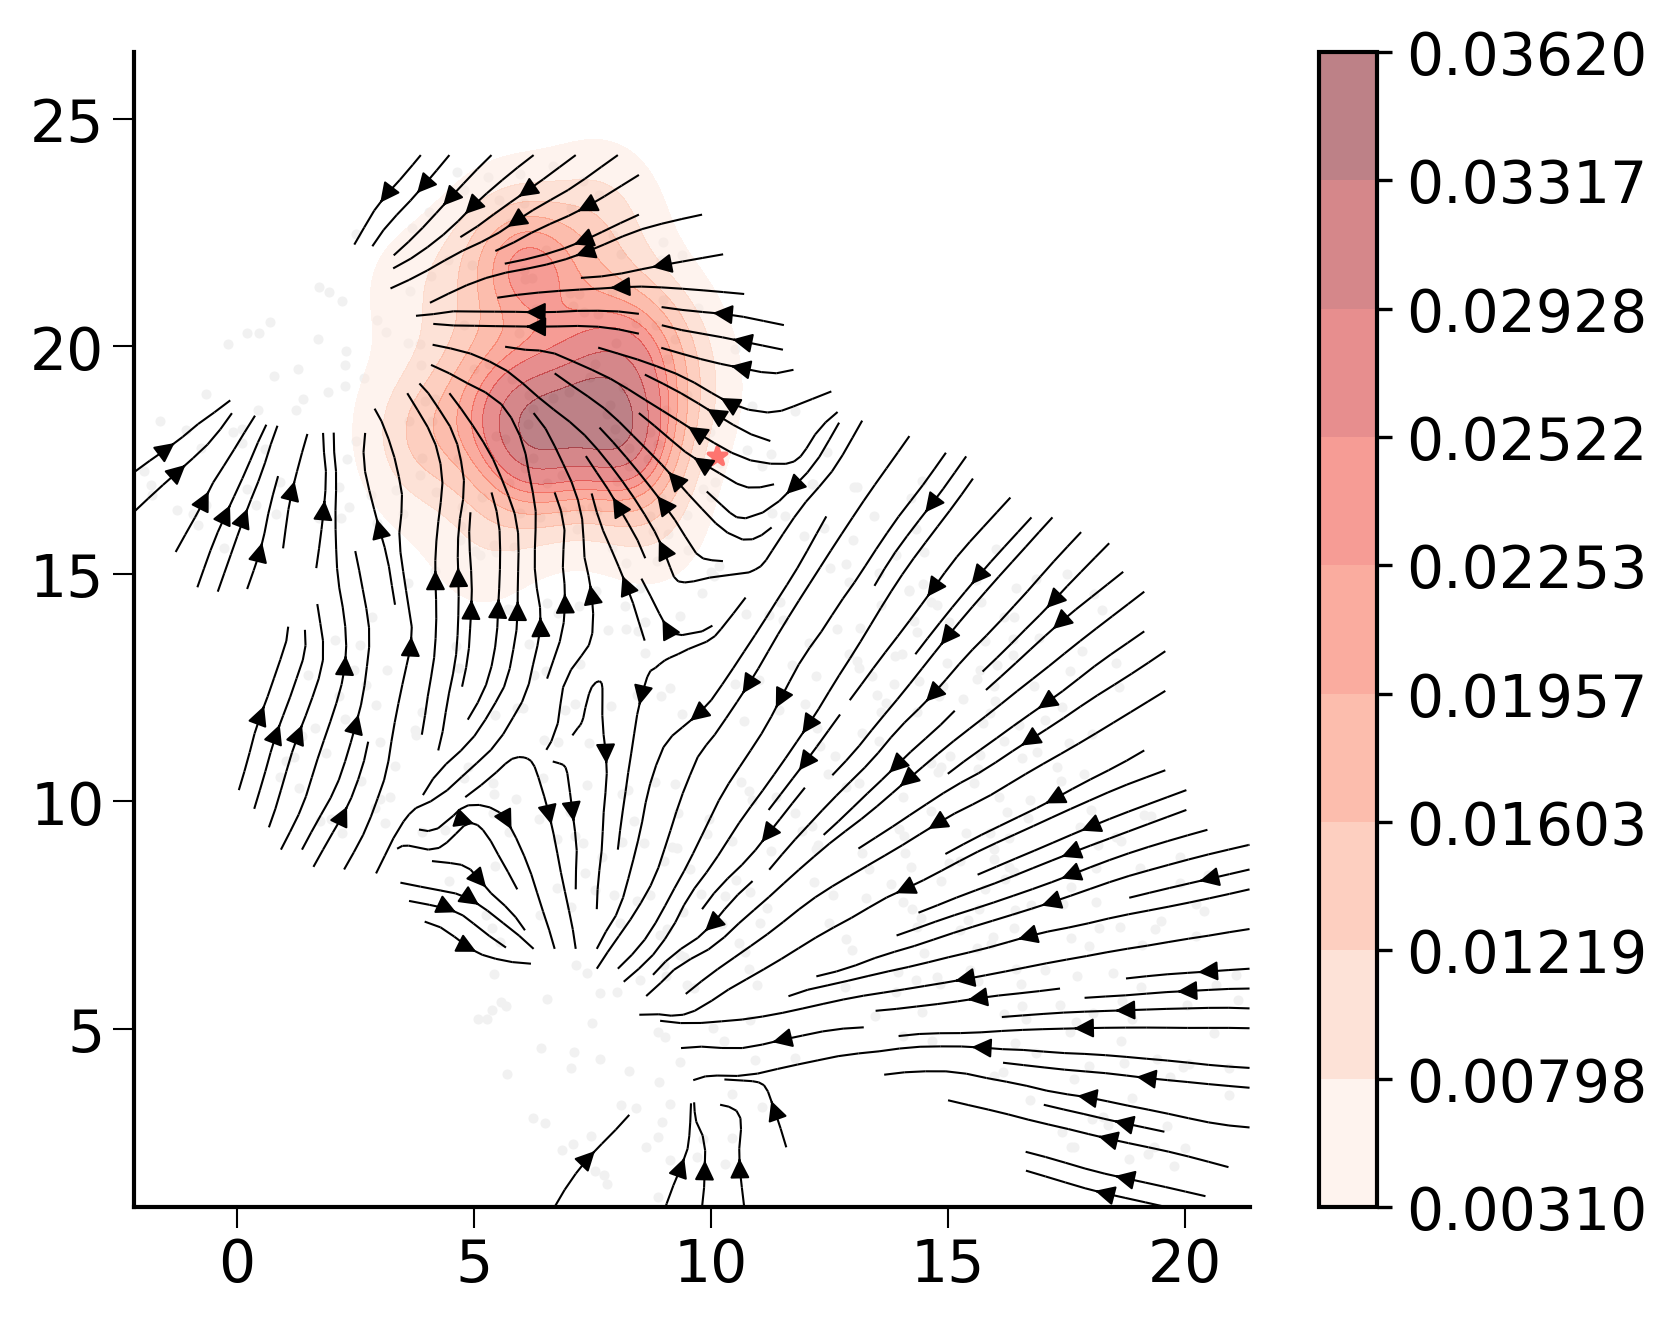

In [438]:
import seaborn as sns

xkey = 'geneEnc'
mkey = 'genemap'
X = adata.obsm['geneEnc'][:,0,:]
M = adata.obsm['genemap'][:,0,:]
N = adata.obsp['connectivities']

fig,ax=createFig()
fig.set_size_inches(6, 5)
palette={
 'Ery': '#2A9E27',
 'Lymphoid': '#E43E96',
 'Mast': '#B5BD61',
 'My': '#279E9E',
 'Mo': '#50C3C6',
 'Neu': '#FAA339',
 'ME': '#279E8F',
 'Ly': '#E43E96',
 'HSC': '#E6DCD9',
    '-':'#E6DCD9'
}
ax.scatter(E[:,0],E[:,1],s=1, linewidths=0,c=list(map(lambda x: palette[x], adata.obs['fate_pred'])))
# ax.scatter(E[:,0],E[:,1],s=1, linewidths=0,c=list(map(lambda x: sc.pl._tools.scatterplots._get_palette(biddy_adata, 'leiden')[x], biddy_adata.obs['leiden'])))
tmp = adata.obs

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
# sc.pl.umap(weinreb_adata, ax=ax, color='Gata2')

i=np.random.choice(list(map(lambda z: z[0], 
                            filter(lambda x: x[1] == '0', 
                                   enumerate(adata.obs['leiden'])))), 1)
i
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=40)
nn.fit(X)
D,I = nn.kneighbors(M[i])
e = E[I][0]


E = adata.obsm["X_umap"]

ax.scatter(
    adata.obsm["X_umap"][:,0],
    adata.obsm["X_umap"][:,1],
    color='#F1F1F1',
    s=2
)

stream_kwargs = {
        "linewidth": 0.5,
        "density": 1.8,
        "zorder": 3,
        "color": "black",
        "arrowsize":  1,
        "arrowstyle": "-|>",
        "maxlength":  10,
        "integration_direction":  "both",
}
ax.streamplot(gE[0],gE[1],gdE[0],gdE[1],**stream_kwargs)

ax.scatter(E[i,0],E[i,1],color='red',s=20,marker='*')
# sns.kdeplot(e[:,0],e[:,1],ax=ax, fill=True, alpha=0.5, cmap='Reds',cbar=True)
sns.kdeplot(x=e[:,0], y=e[:,1], ax=ax, fill=True, alpha=0.5, cmap='Reds', cbar=True)


In [439]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('/home/zhengtuo/songtao/DestinyNet/carlin_figure/fateflow_hotpot4.pdf') as pdf:
    pdf.savefig(fig, bbox_inches='tight')

In [168]:
top_genes

Index(['Mllt3', 'Hnrnpa1', 'Eif5a', 'Scaper', 'Tmem71', 'Casc3', 'Hacd4',
       'Prnp', 'Neurl3', 'Zscan2', 'Nkx2-3', 'Psmb4', 'Jun', 'Ssb', 'Psmb8',
       'Ifi27', 'Flt3', 'Ctsl', 'H2-K1', 'Pde4b'],
      dtype='object')

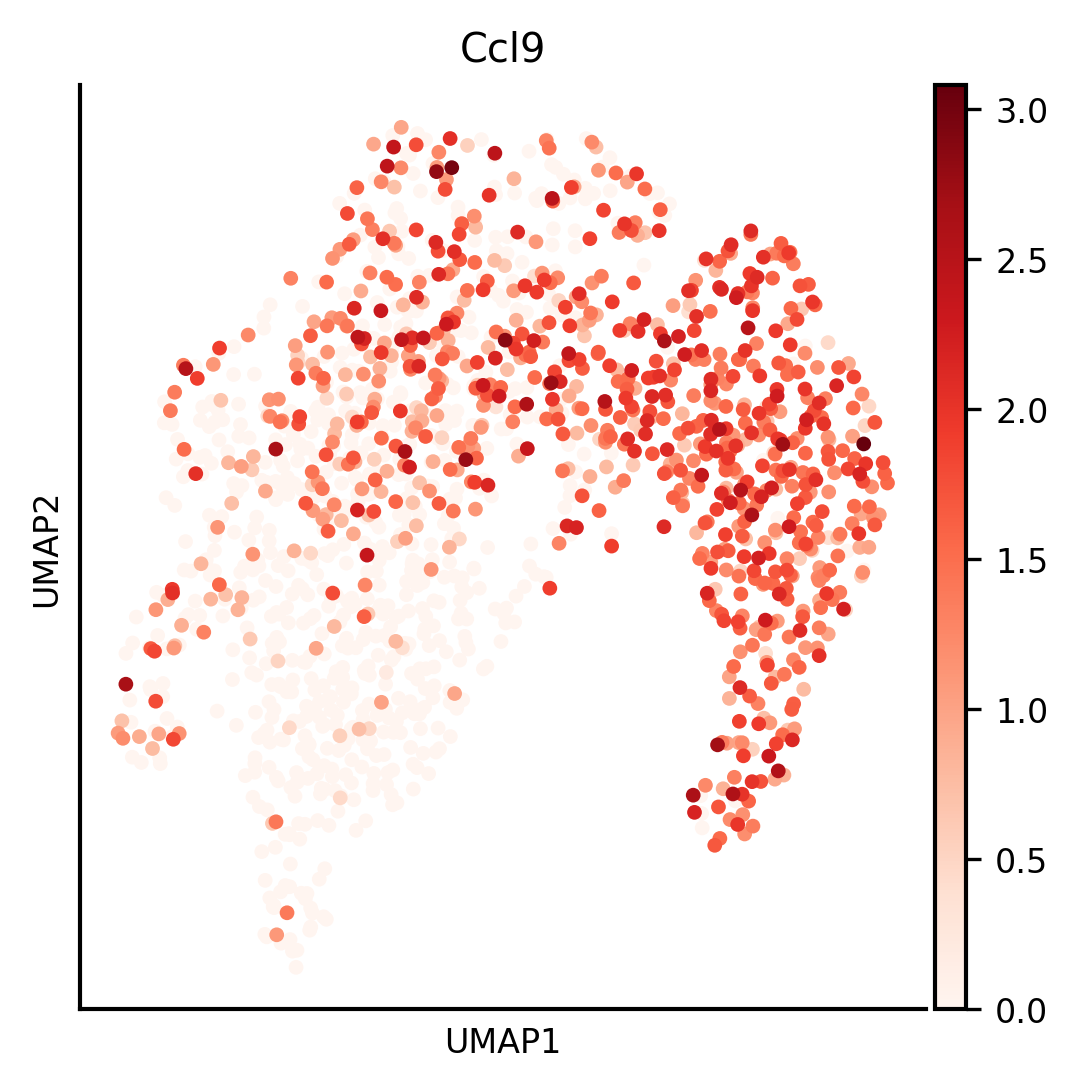

In [61]:
fig,ax=createFig(figsize=(4,4))
sc.pl.umap(adata,color='Ccl9',ax=ax,s=50,cmap='Reds',vmin=0)#Apoe,Ifitm1,Mpl,Dntt


/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


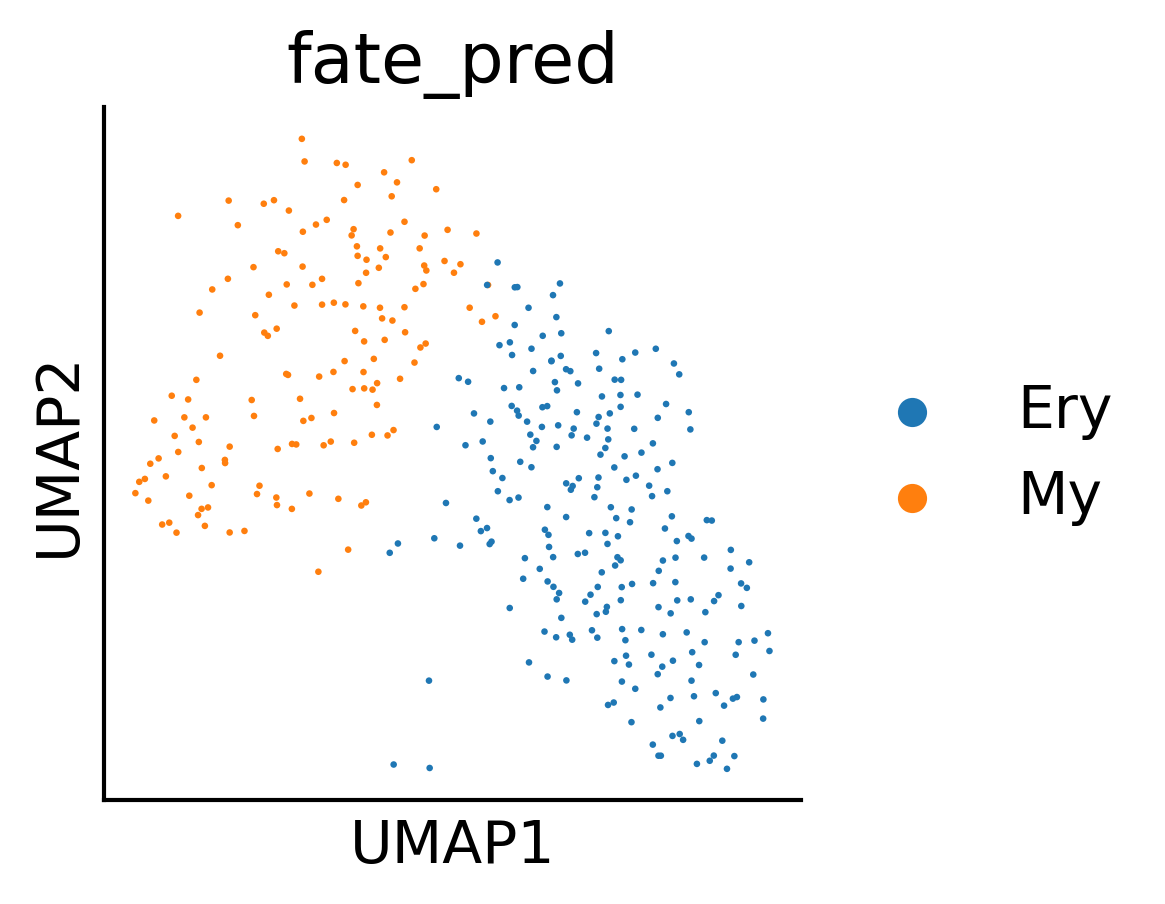

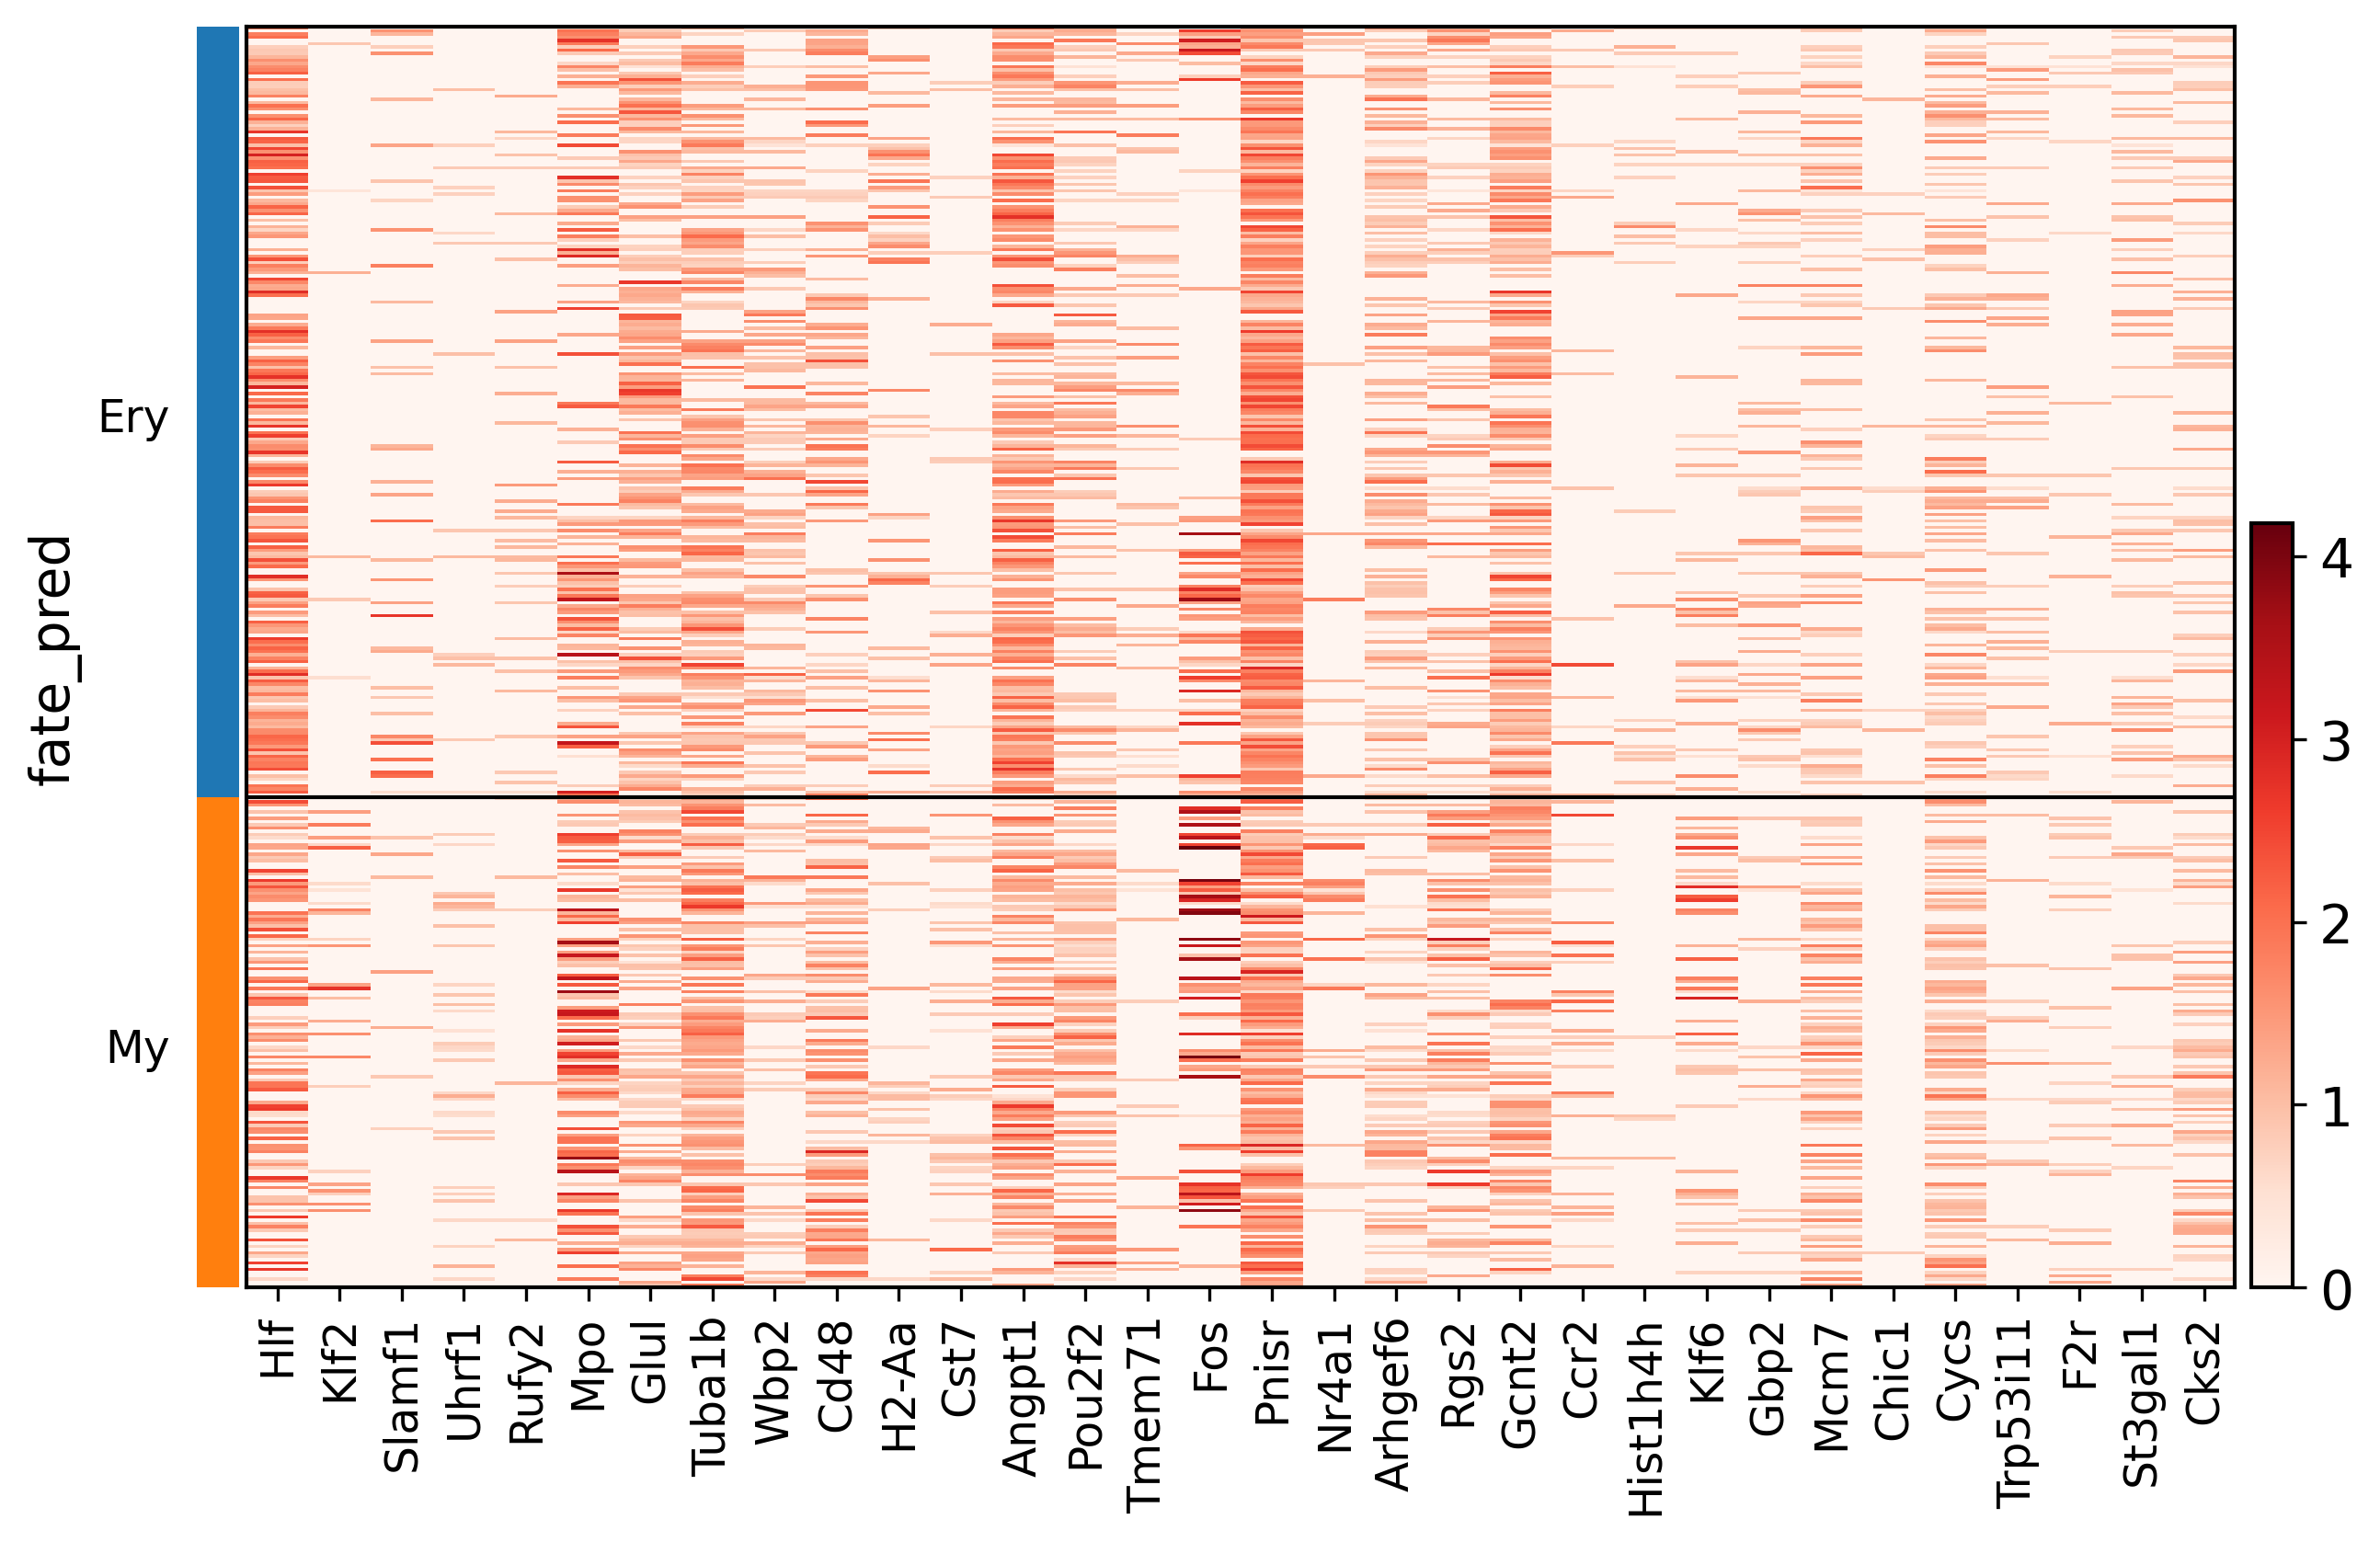

In [440]:
#adata2.obsm['X_pca']=adata2.obsm['X_pca'].cpu().numpy()
adata3=adata2[(adata2.obs['reannotation']=='HSC')&(adata2.obs['fate_pred'].isin(['My','Ery']))]
from sklearn.neighbors import KNeighborsClassifier
plt.rcParams['font.size'] = 14
fig,ax=createFig(figsize=(3,3)) 
sc.pl.umap(adata3,color=['fate_pred'],ax=ax,s=10)
sc.tl.rank_genes_groups(adata3, groupby='fate_pred', method='t-test_overestim_var')

sc.pl.heatmap(
    adata3[list(map(lambda x: type(x) == str, adata3.obs['fate_pred']))],  
    pd.DataFrame(adata3.uns['rank_genes_groups']['names']).head(16).to_numpy().flatten(), 
    groupby='fate_pred', cmap='Reds'
    
)

In [ ]:
"Ery": "#2B9E44",
    "My": "#289E9E",

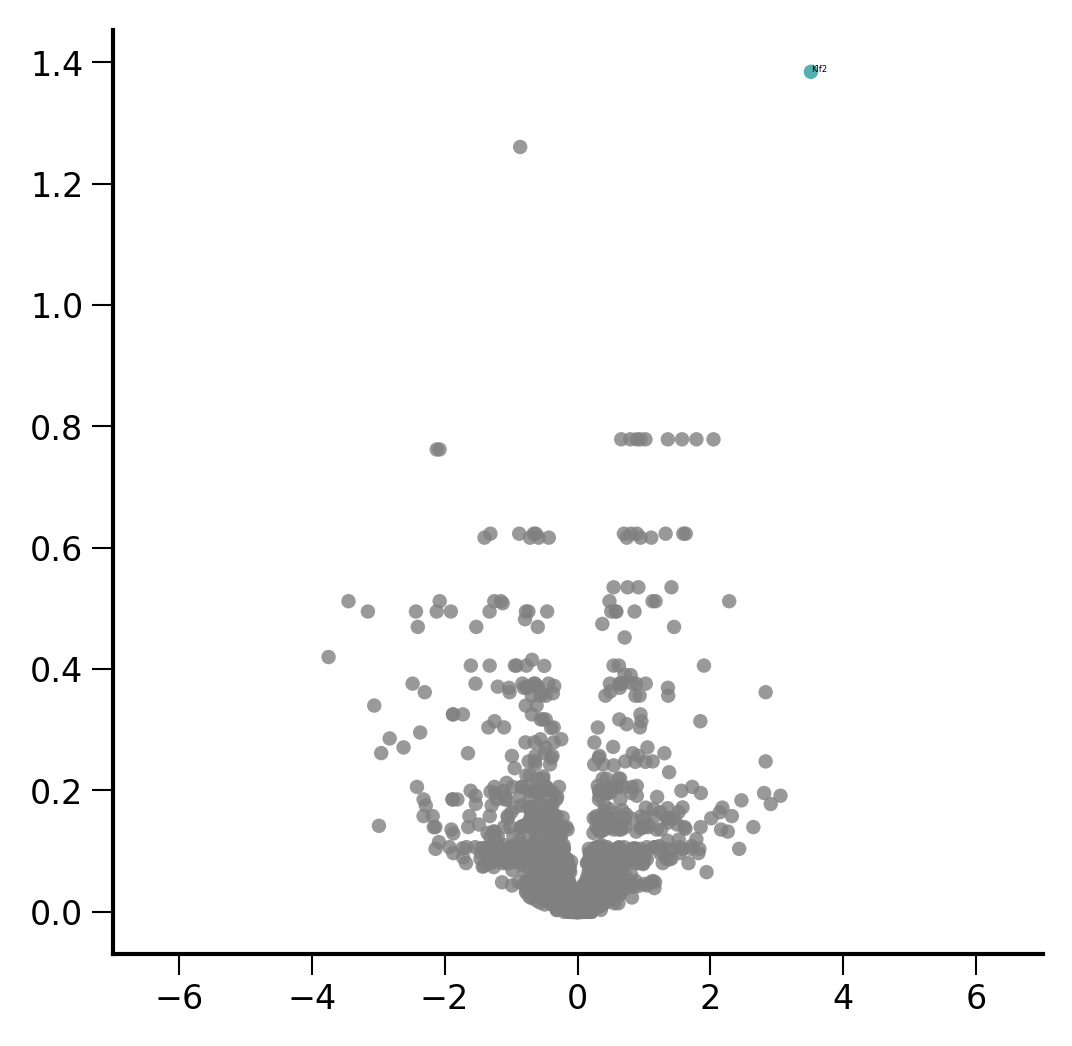

In [442]:
plt.rcParams['font.size'] = 8
fig,ax=ScanpyVolcanoPlot(
    adata3, 
    1, label_log_p=1.3, 
    show_label=True, 
    label_fold_change=1, 
    label_size=2,
    add_grid=False,
    color1='#289E9E',
    color2='#2B9E44',
)
ax.set_xbound(-7,7)
fig.set_size_inches(4,4)
fig.savefig("/home/zhengtuo/songtao/DestinyNet/carlin_figure/carlin_volcano.pdf", dpi=1000)


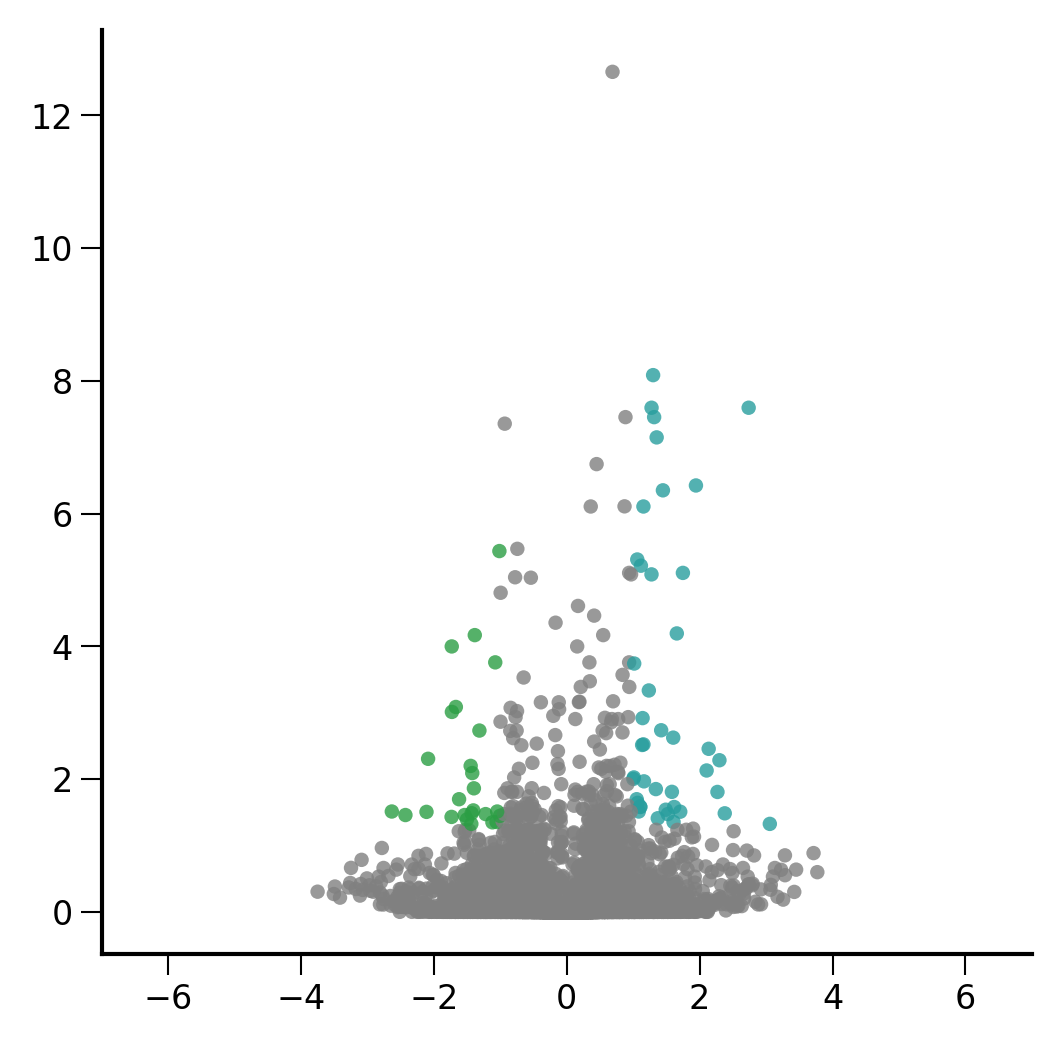

In [63]:
plt.rcParams['font.size'] = 8
fig,ax=ScanpyVolcanoPlot(
    adata3, 
    1, label_log_p=1.3, 
    show_label=False, 
    label_fold_change=1, 
    label_size=2,
    add_grid=False,
    color1='#289E9E',
    color2='#2B9E44',
)
ax.set_xbound(-7,7)
fig.set_size_inches(4,4)
fig.savefig("/home/zhengtuo/songtao/DestinyNet/carlin_figure/carlin_volcano_nowords.pdf", dpi=1000)


In [388]:
adata3_GT=adata[adata.obs['preference_HSC'].isin(['My','Ery'])]
sc.tl.rank_genes_groups(adata3_GT, groupby='preference_HSC', method='t-test_overestim_var')


/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


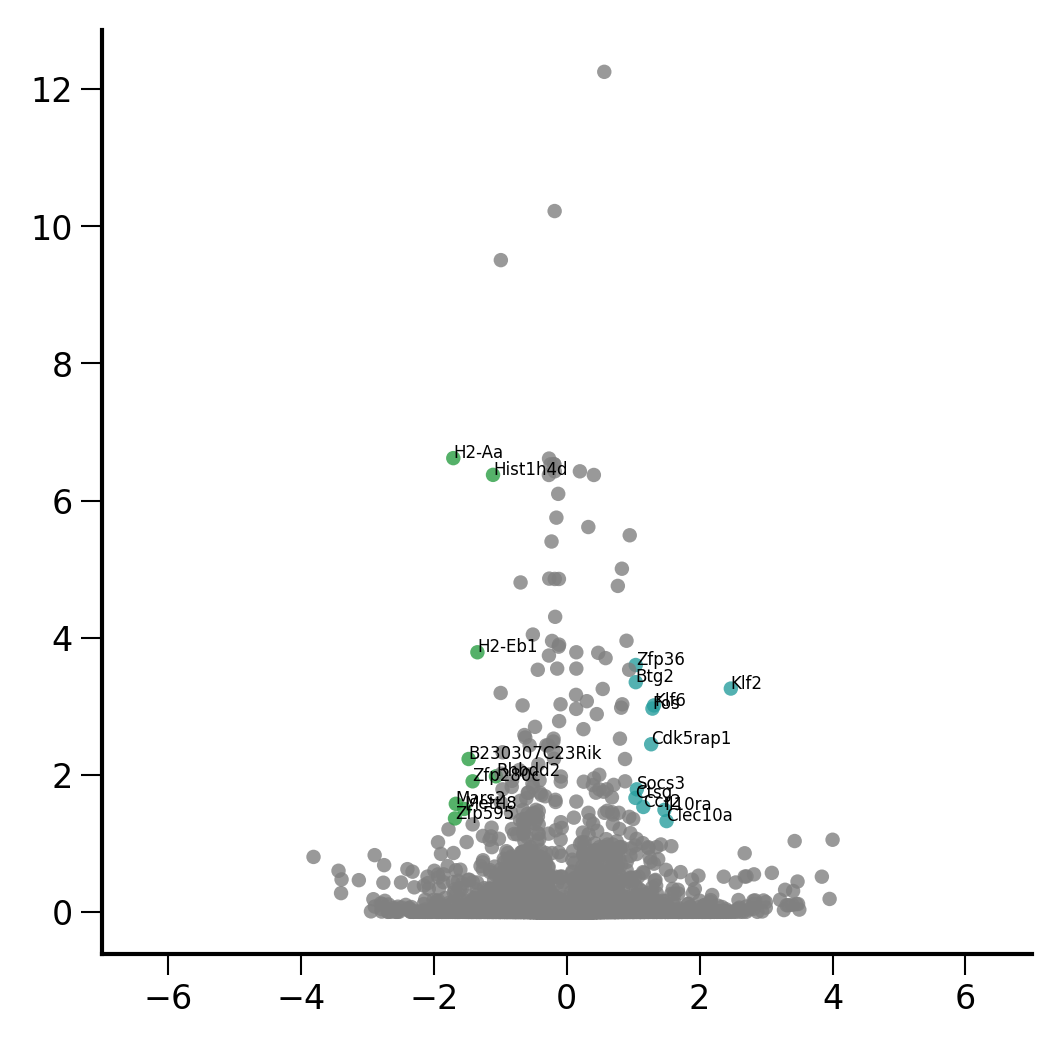

In [64]:

plt.rcParams['font.size'] = 8
fig,ax=ScanpyVolcanoPlot(
    adata3_GT, 
    1, label_log_p=1.3, 
    show_label=True, 
    label_fold_change=1, 
    label_size=4,
    add_grid=False,
    color1='#289E9E',
    color2='#2B9E44',
)
ax.set_xbound(-7,7)
fig.set_size_inches(4,4)
fig.savefig("/home/zhengtuo/songtao/DestinyNet/carlin_figure/carlin_volcano_GT.pdf", dpi=1000)


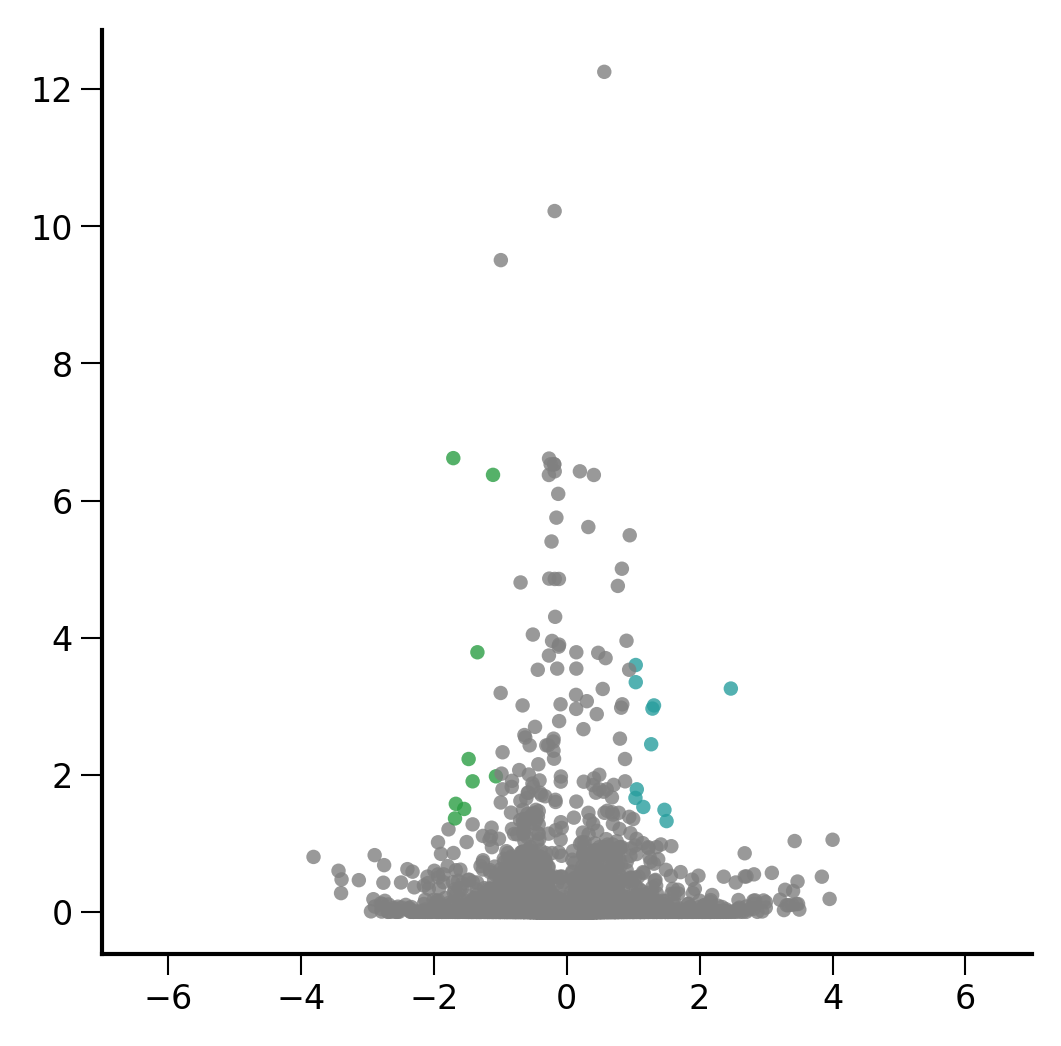

In [65]:

plt.rcParams['font.size'] = 8
fig,ax=ScanpyVolcanoPlot(
    adata3_GT, 
    1, label_log_p=1.3, 
    show_label=False, 
    label_fold_change=1, 
    label_size=4,
    add_grid=False,
    color1='#289E9E',
    color2='#2B9E44',
)
ax.set_xbound(-7,7)
fig.set_size_inches(4,4)
fig.savefig("/home/zhengtuo/songtao/DestinyNet/carlin_figure/carlin_volcano_GT_nowords.pdf", dpi=1000)


In [378]:
adata

AnnData object with n_obs × n_vars = 1558 × 20863
    obs: 'sample_name', 'leiden', 'reannotation', 'preference', 'preference_HSC', 'preference_MPP', 'index', 'fate_pred', 'prob'
    uns: 'fate_pred_colors', 'neighbors', 'preference_HSC_colors', 'reannotation_colors', 'umap'
    obsm: 'X_emb', 'X_emb_old', 'X_pca', 'X_pca_sct', 'X_umap', 'X_umap_sct', 'geneEnc', 'genemap'
    obsp: 'connectivities', 'distances'

In [41]:
import seaborn as sns
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
import torch.nn as nn

def compute_gradients_for_label(target_label, data, model_encoder, model_decoder):
    mask = data.obs['fate_pred'] == target_label
    filtered_data = data[mask]
    
    geneex_data = torch.tensor(filtered_data.X.toarray(), dtype=torch.float32).to(device2)
    
    dataset = TensorDataset(geneex_data)
    dataloader = DataLoader(dataset, batch_size=256, shuffle=False)
    
    total_gradients = torch.zeros(len_geneExp).to(device2)
    for batch in dataloader:
        geneExp = batch[0]
        geneExp = Variable(geneExp, requires_grad=True)
        output_data = model_encoder(geneExp)
        output_data = model_decoder(output_data)
        
        loss_function = nn.MSELoss()
        loss = loss_function(output_data, geneExp)
        
        model_encoder.zero_grad()
        model_decoder.zero_grad()
        loss.backward()

        total_gradients += geneExp.grad.abs().mean(dim=0)

    average_gradients = total_gradients / len(dataloader)
    return average_gradients

labels = ['My', 'Ery']
gradients_per_label = {}

for label in labels:
    gradients_per_label[label] = compute_gradients_for_label(label, adata, geneEnc, geneDec)


In [42]:
num_key_genes = 50  

key_genes_per_label = {}

for label, gradients in gradients_per_label.items():
    df = pd.DataFrame({
        'gene_ids': adata.var.index.values,
        'importance': gradients.cpu().detach().numpy()
    })

    sorted_df = df.sort_values(by="importance", ascending=False)
    
    key_genes = sorted_df['gene_ids'].head(num_key_genes).tolist()  
    key_genes_per_label[label] = key_genes

for label, genes in key_genes_per_label.items():
    print(f"Key genes for label {label}:")
    print(', '.join(genes))
    print("\n")


Key genes for label My:
H2afy, Ifitm1, Srgn, Plac8, Ctla2a, Lmo2, Rpl31, Ncl, Sox4, Ifitm3, Zfp36l2, Ptprcap, Car2, Calr, Tmsb10, Vim, Jun, Hspe1, Stmn1, Cdk6, Prtn3, Cd34, Adgrl4, Adgrg1, Tubb5, Mpo, Pim1, Txnip, Msi2, Pnrc1, Ldha, Mef2c, Ogt, Samsn1, Akap13, Ier2, Serinc3, Ubc, Pnisr, Fos, Ifi203, Egfl7, Jund, Limd2, Hmgb2, Dapp1, Tspo, Hlf, H2-T23, Serpinb1a


Key genes for label Ery:
H2afy, Ifitm1, Srgn, Lmo2, Ctla2a, Rpl31, Ifitm3, Plac8, Zfp36l2, Sox4, Car2, Ncl, Ptprcap, Calr, Txnip, Prtn3, Vim, Hlf, Tmsb10, Adgrg1, Pim1, Pnrc1, Adgrl4, Stmn1, Ogt, Pnisr, Cd34, Ifi203, Msi2, Hspe1, Serinc3, Gimap1, Ptpre, Dapp1, Cdk6, Akap13, Jun, Tubb5, Aes, H2-Q7, Angpt1, Limd2, Gimap6, Cd63, Ubc, Foxp1, Ltb, Tspo, H2-T23, Dcun1d1




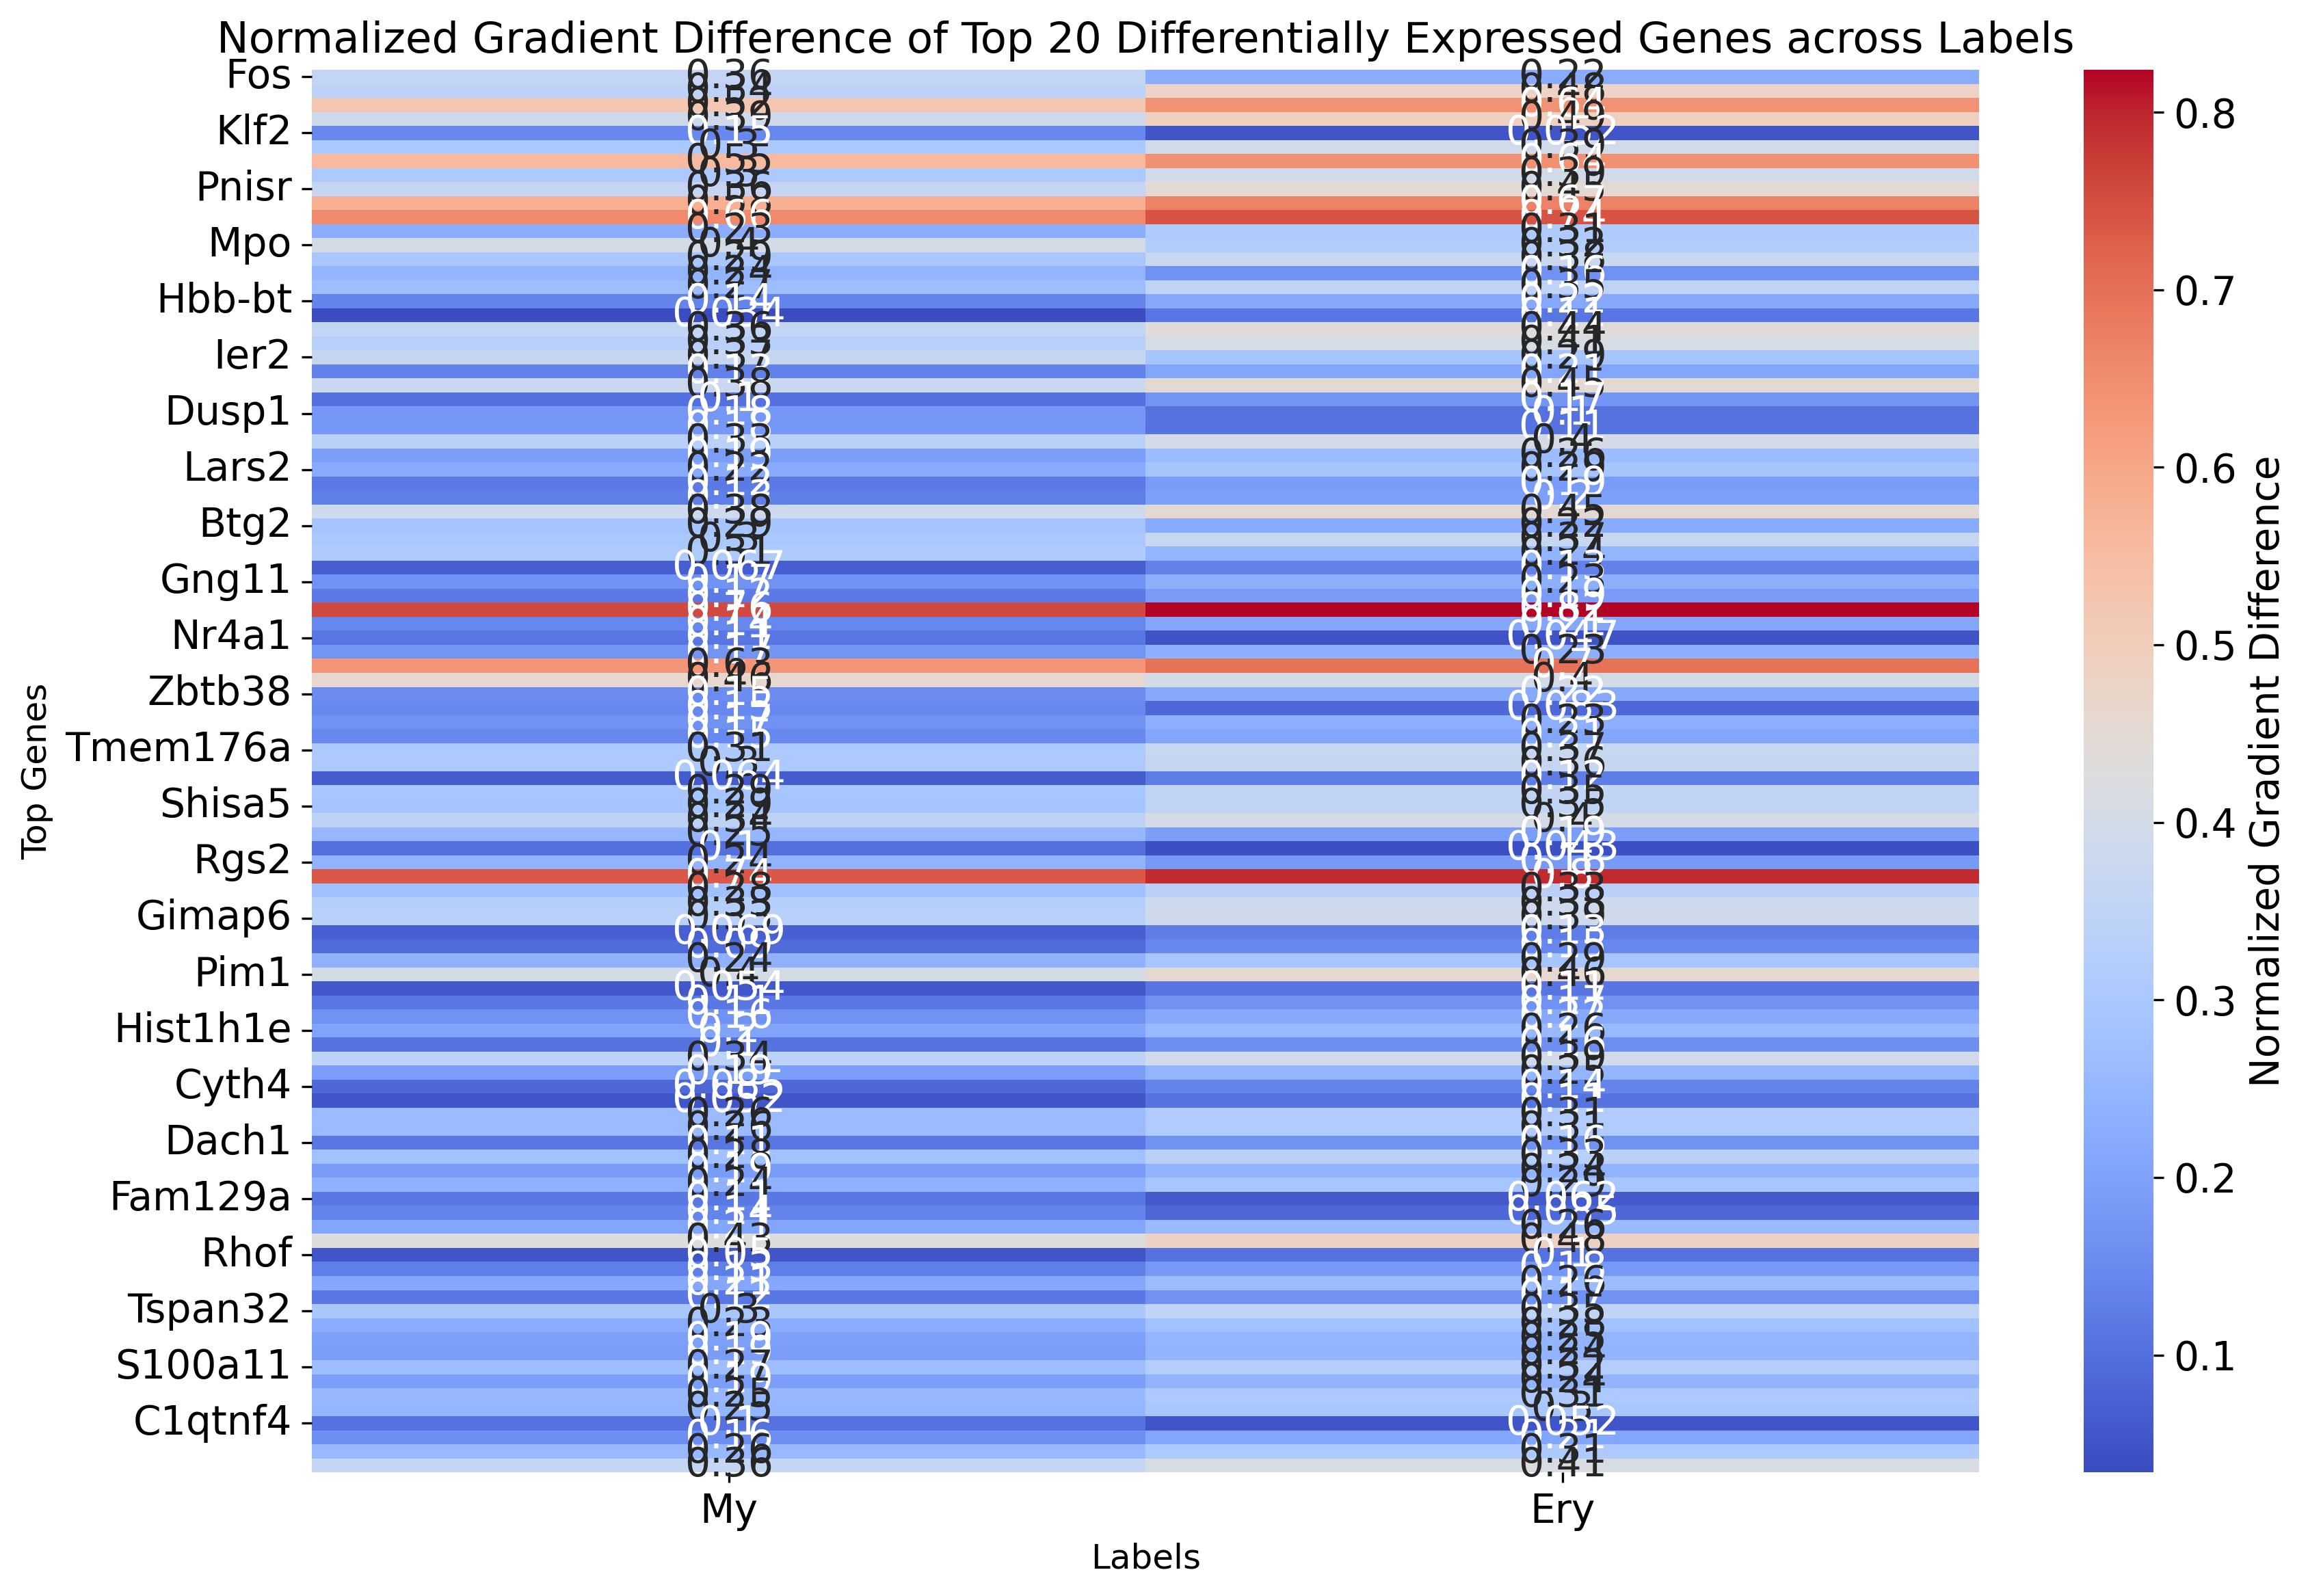

In [56]:
gradient_data = {}
for label, gradients in gradients_per_label.items():
    gradient_data[label] = gradients.cpu().detach().numpy()

df_gradients_all = pd.DataFrame(gradient_data, index=adata.var.index.values)

def normalize(column):
    """Normalize a pandas column to range between 0 and 1"""
    min_val = column.min()
    max_val = column.max()
    return (column - min_val) / (max_val - min_val)

# Normalize gradients for each label
for label in labels:
    df_gradients_all[label] = normalize(df_gradients_all[label])

# Compute difference between normalized gradients for the two labels
df_gradients_all['diff'] = (df_gradients_all[labels[0]] - df_gradients_all[labels[1]])

# Select the top 20 genes with the largest gradient difference
top_genes = df_gradients_all['diff'].abs().nlargest(100).index

# Extract the normalized gradient values for the top genes
df_gradient_top = df_gradients_all.loc[top_genes, labels]

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_gradient_top, cmap="coolwarm", annot=True, cbar_kws={'label': 'Normalized Gradient Difference'})
plt.title("Normalized Gradient Difference of Top 20 Differentially Expressed Genes across Labels", fontsize=15)
plt.ylabel('Top Genes', fontsize=12)
plt.xlabel('Labels', fontsize=12)
plt.tight_layout()
plt.show()

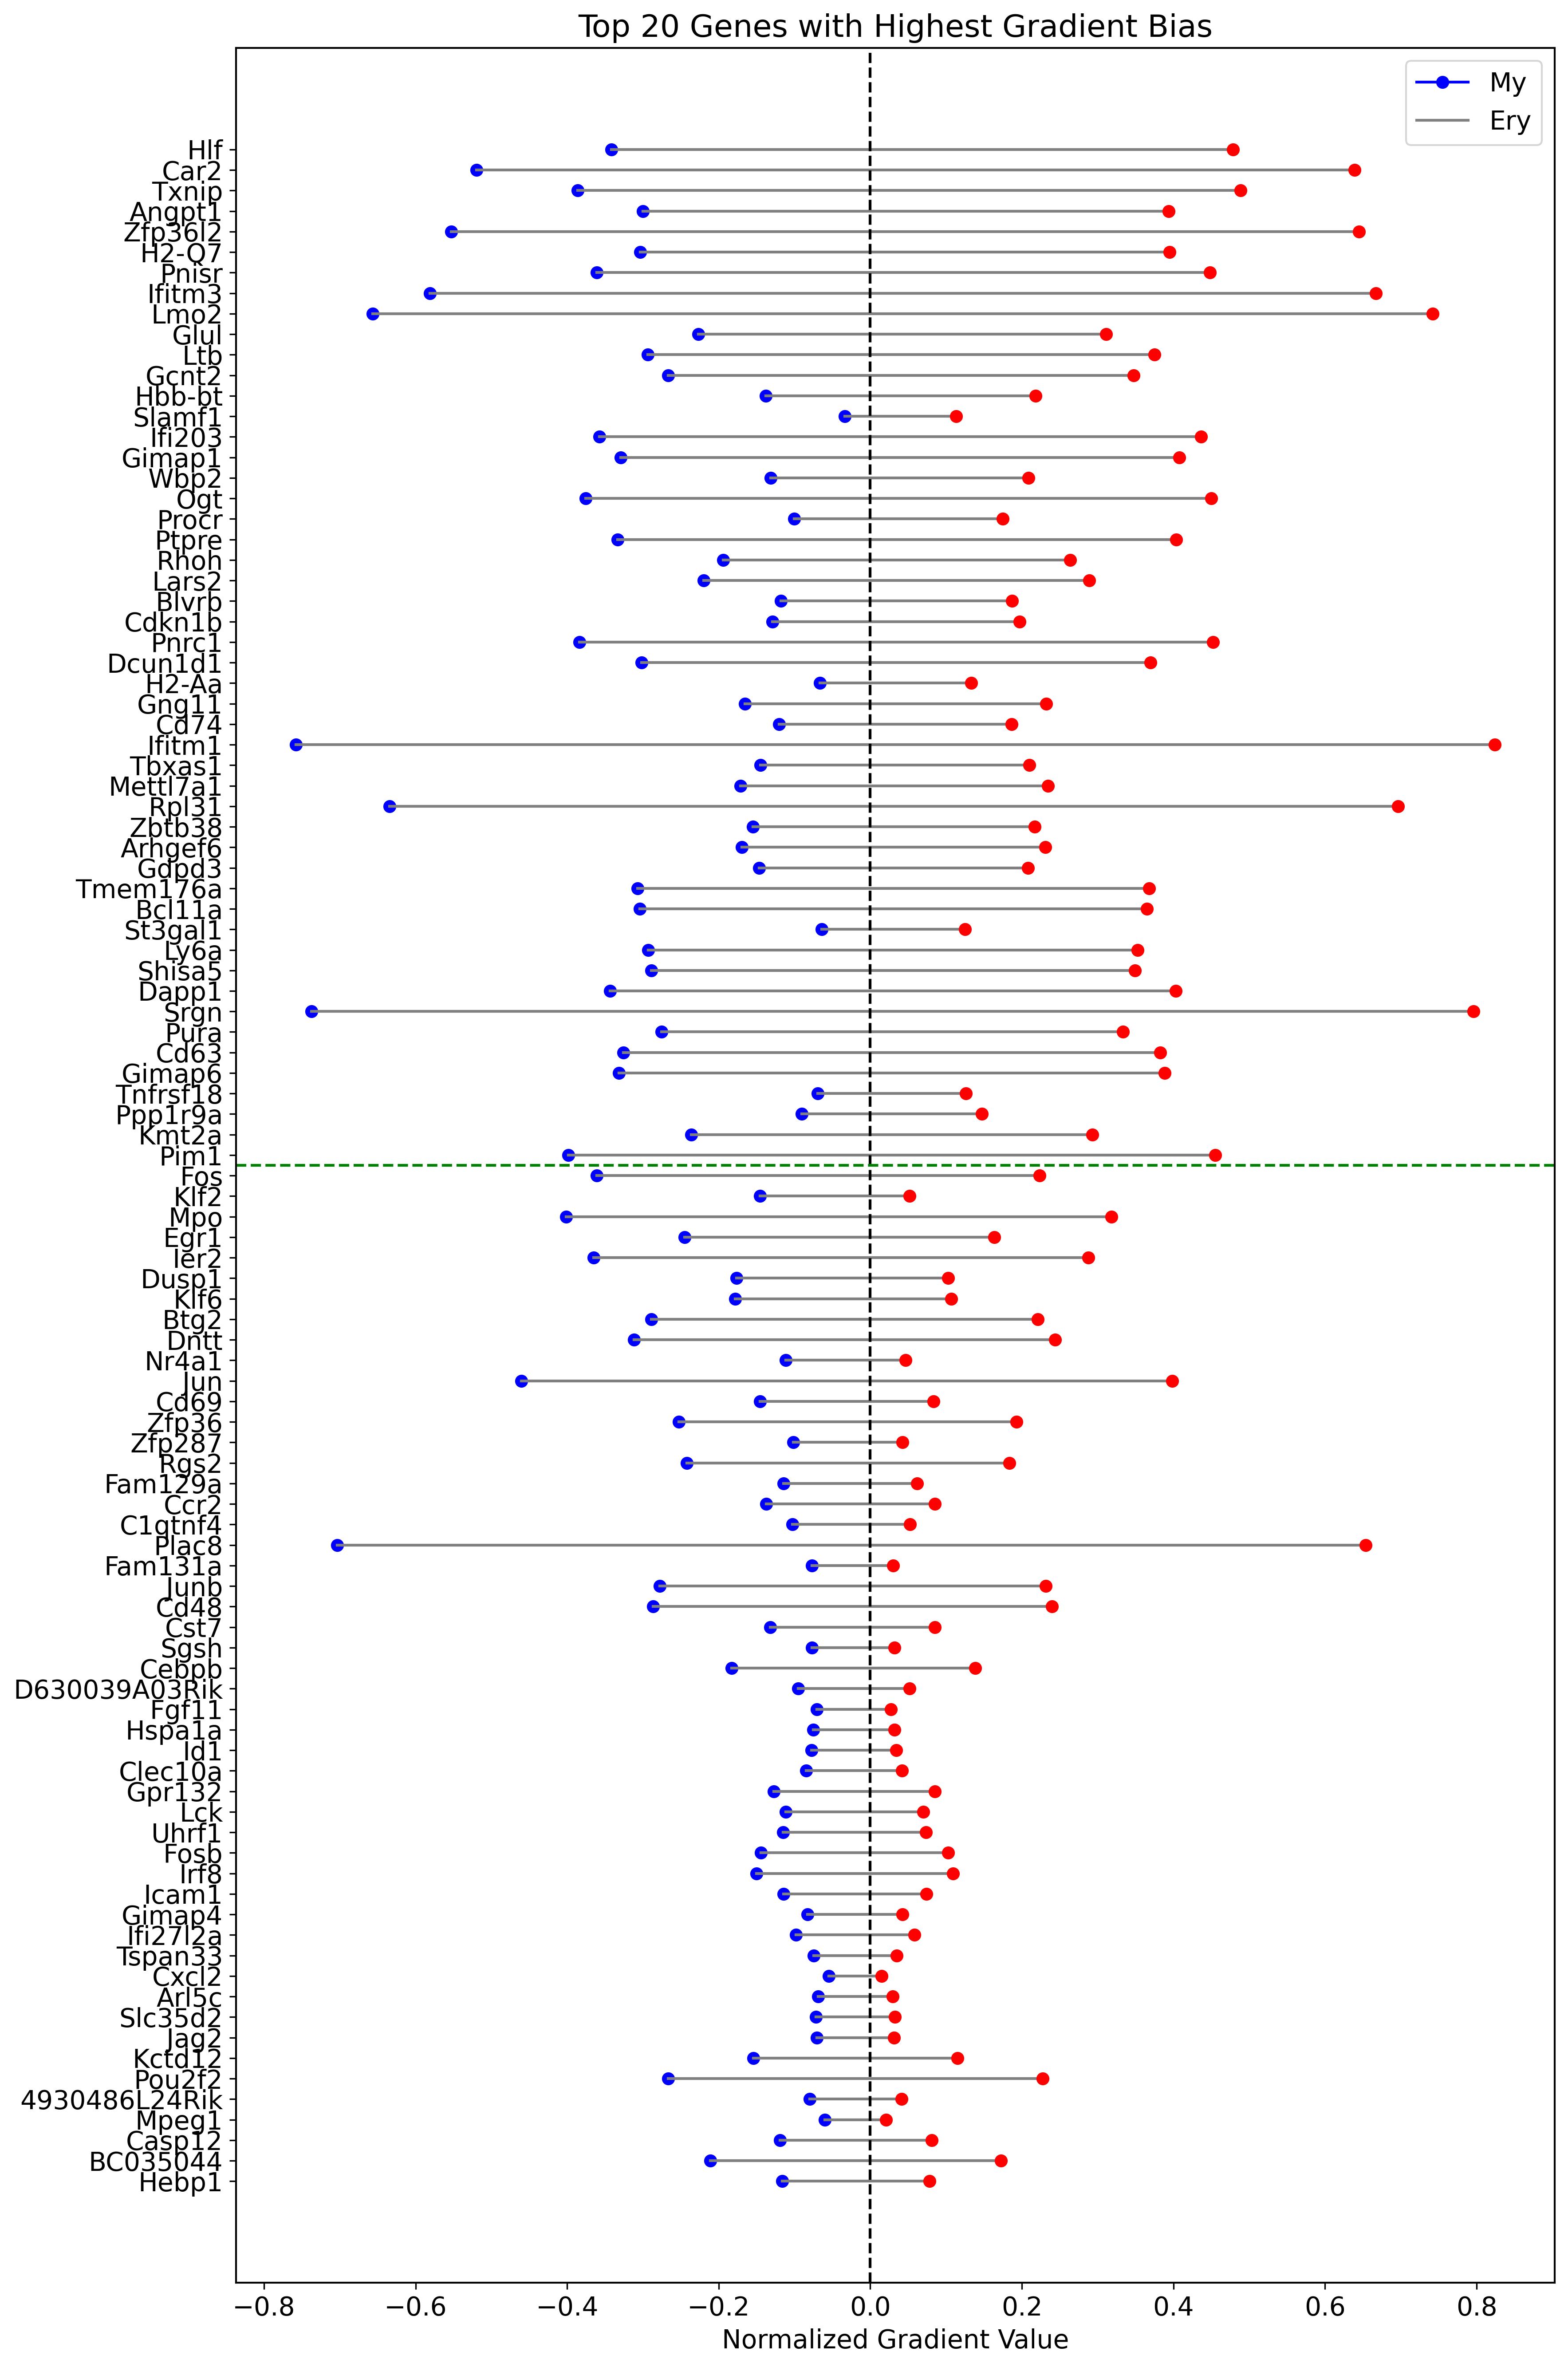

In [57]:
import matplotlib.pyplot as plt
df_gradients_all_normalized = df_gradients_all.copy()
for label in labels:
    df_gradients_all_normalized[label] = (df_gradients_all[label] - df_gradients_all[label].min()) / (df_gradients_all[label].max() - df_gradients_all[label].min())
num=50
df_gradients_all_normalized[labels[0]] = -df_gradients_all_normalized[labels[0]]

df_gradients_all_normalized['bias'] = df_gradients_all_normalized[labels[1]] + df_gradients_all_normalized[labels[0]]

sorted_df_right_bias = df_gradients_all_normalized.sort_values(by='bias', ascending=False).head(num)
sorted_df_right_bias =sorted_df_right_bias.sort_values(by='bias', ascending=True)

sorted_df_left_bias = df_gradients_all_normalized.sort_values(by='bias').head(num)
sorted_df_left_bias =sorted_df_left_bias.sort_values(by='bias', ascending=False)
top_genes_bias = pd.concat([sorted_df_left_bias, sorted_df_right_bias])
#top_genes_bias = top_genes_bias.sort_values(by='bias', key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(12, 18))

colors = ['blue', 'red']

for gene in top_genes_bias.index:
    for i, label in enumerate(labels):
        x_value = top_genes_bias.loc[gene, label]
        y_value = list(top_genes_bias.index).index(gene)
        ax.plot(x_value, y_value, marker='o', color=colors[i])
        if i == 0:
            x_values = [top_genes_bias.loc[gene, labels[0]], top_genes_bias.loc[gene, labels[1]]]
            y_values = [y_value, y_value]
            ax.plot(x_values, y_values, linestyle='-', color='grey')

ax.axvline(0, color='black', linestyle='--')

divider_position = num
ax.axhline(divider_position - 0.5, color='green', linestyle='--')

ax.set_yticks(range(len(top_genes_bias.index)))
ax.set_yticklabels(top_genes_bias.index)
ax.set_title('Top 20 Genes with Highest Gradient Bias')
ax.set_xlabel('Normalized Gradient Value')
ax.legend(labels, loc='upper right')

plt.tight_layout()
plt.show()
fig.savefig("/home/zhengtuo/songtao/DestinyNet/carlin_figure/carlin_lolipop_plot_top50.pdf", dpi=1000)

In [25]:
dic1={'Mo':'My','Neu':'My','Mk':'Ery','HSC':'HSC','Ery':'Ery'}

adata.obs['reannotation']=adata.obs['reannotation'].map(dic1)
adata.obs['reannotation'].value_counts()

HSC    386
Ery    119
My     107
Name: reannotation, dtype: int64

In [59]:
import pandas as pd

df = pd.read_csv('/home/zhengtuo/songtao/tf.csv')

filtered_df = df[df['Symbol'].isin(top_genes)]['Symbol']

print(filtered_df.values)


['Hlf' 'Egr1' 'Zfp36l2' 'Zfp287' 'Zbtb38' 'Pura' 'Pou2f2' 'Nr4a1' 'Klf6'
 'Klf2' 'Junb' 'Jun' 'Irf8' 'Id1' 'Fosb' 'Fos' 'Cebpb' 'Bcl11a']


/home/zhengtuo/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


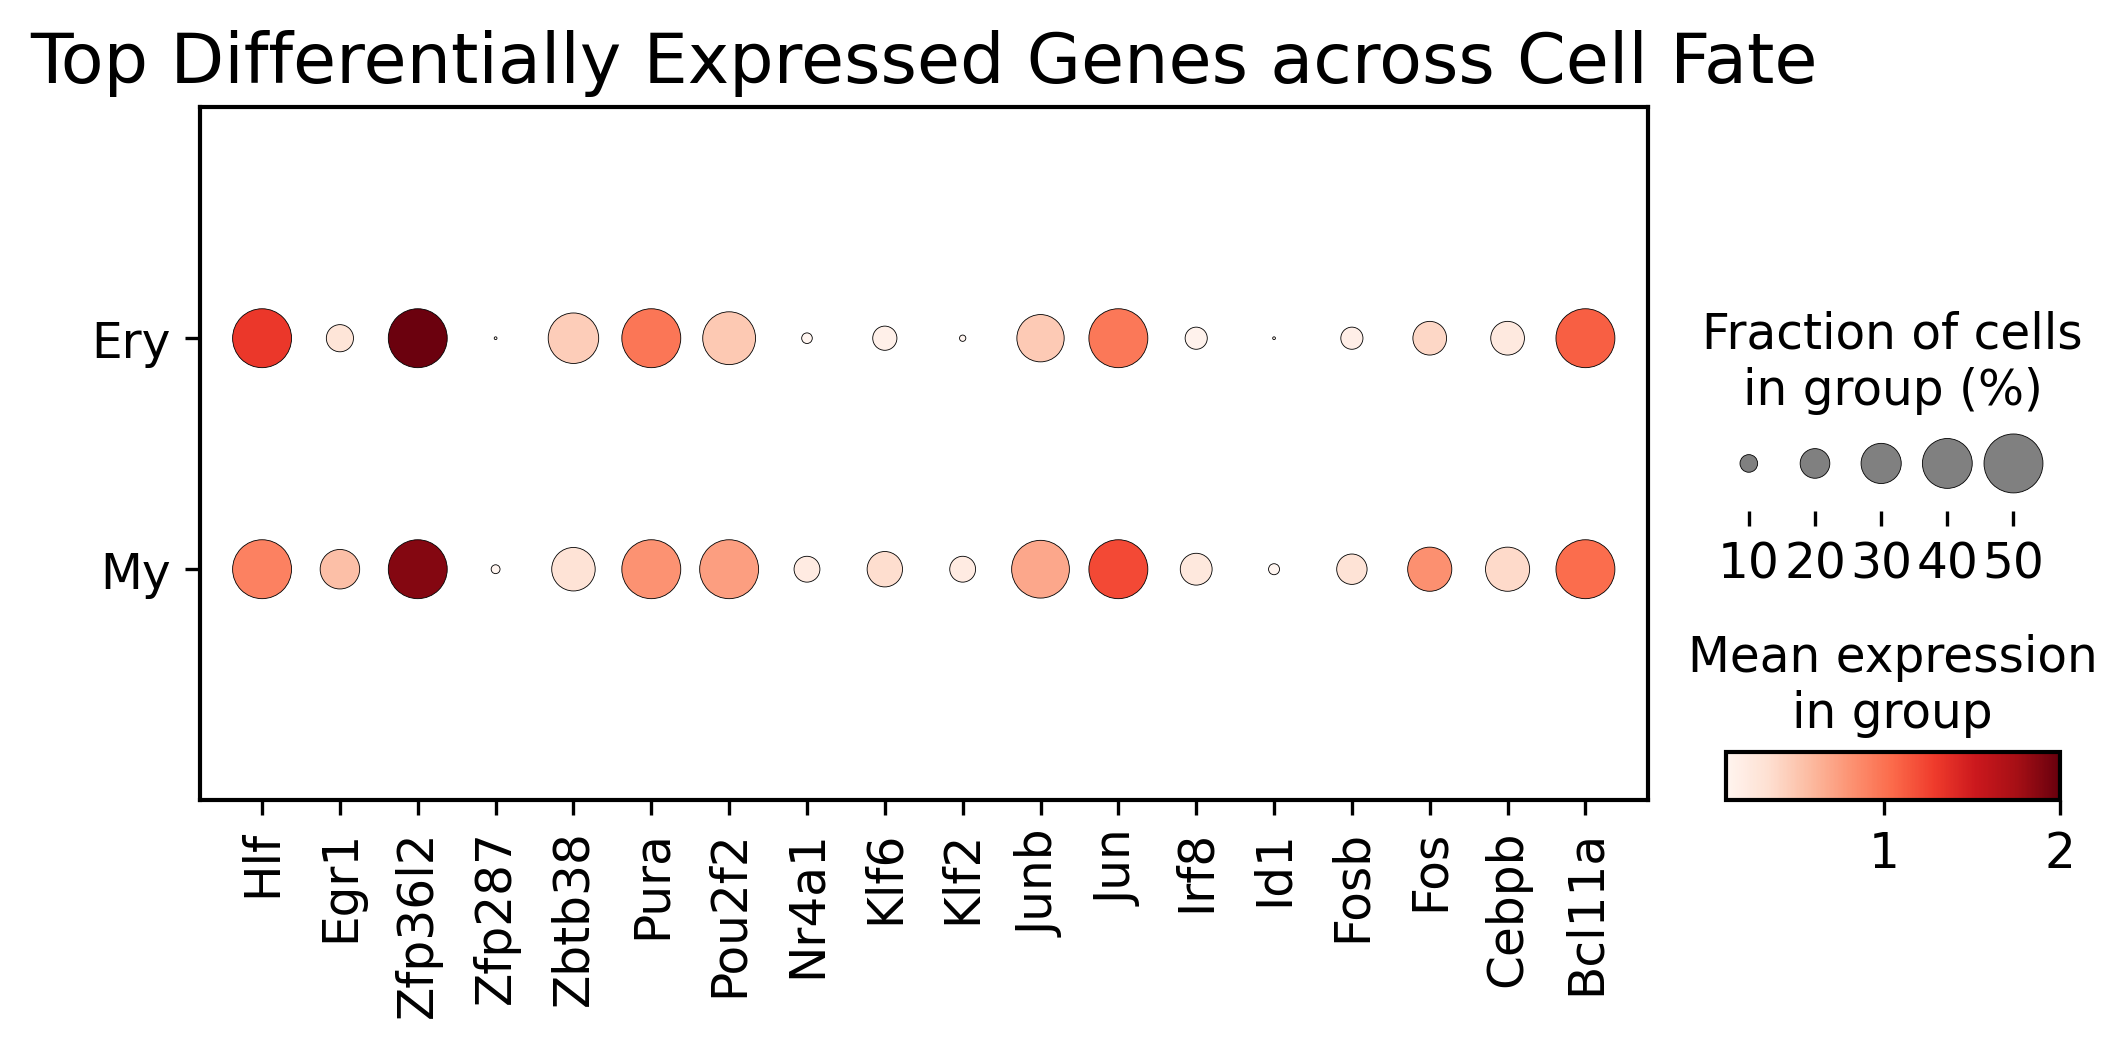

In [62]:

import anndata
# df_expression_all['diff'] = df_expression_all[labels[0]] - df_expression_all[labels[1]]
top_genes =  top_genes_bias[::-1].index

sc.pl.dotplot(adata[adata.obs['fate_pred']!='-'], 
              var_names=filtered_df.values, 
              groupby='fate_pred', 
              figsize=(8, 3), 
              dot_max=0.5, 

              color_map='Reds',
              title="Top Differentially Expressed Genes across Cell Fate",
              vmin=0.1,
              vmax=2,
              save='carlin_dotplot_top50_tf.pdf')


In [137]:
x_indices = list(map(lambda x: x[0], sorted(enumerate(_biddy_adata.obs['dic_fate_prob']), key=lambda x: x[1])))
var_names = ['Apoa1','S100a13','Gsto1','Msln','Cd9','Timp3','Rbp1','2200002D01Rik','Ccnd1','S100a6','Ly6a','Sorbs2','Anxa3','Plac8','Spint2','Fabp5','Fbn2','Thbs1','Fstl1','Igf2','Rcn3','Serpine2','Col5a2','Aebp1','Cdh11','Itm2a','Ifitm2','Igfbp4','Col6a1','Ogn','Cxcl12','Cryab','Bgn','Marcks','Cxcl15','Fzd1','Gas1','Spp1','Svep1','Loxl1','Mmp2','Ifitm3','Col1a2','Tcf4','Sparc','Peg3','Col1a1','Igfbp2','Col3a1','Il6st']
y_indices = list(map(lambda x: list(_biddy_adata.var.index).index(x), var_names))

expr = _biddy_adata.raw.to_adata().X[x_indices,:,][:,y_indices]
expr = pd.DataFrame(expr, columns=var_names)
cmap = make_colormap(['#E4B748','#F7F7F7','#E5499B'])
fig=sns.clustermap(
    expr, 
    row_cluster=False, 
    col_cluster=False, 
    z_score=1, 
    
    cmap='seismic', 
    col_colors=['#E5499B'] * 16 + ['#E4B748'] * (len(var_names) - 16), 
    row_colors=list(map(lambda x: cmap(x), _biddy_adata.obs['dic_fate_prob'][x_indices])),
    center=0
)
fig.savefig("/Users/snow/Downloads/20230914_LT_Pseudotime_Biddy_prob_gene_exp/heatmap.pdf")
fig.savefig("/Users/snow/Downloads/20230914_LT_Pseudotime_Biddy_prob_gene_exp/heatmap.png")

'#289E9E'

In [409]:
adata2.obs['prob']

AAACGCTTCTTCCTAA-1                   None
AAAGGATGTCAGACTT-1    0.07216494530439377
AAAGGATGTGGGTATG-1                   None
AACAAAGAGTAGGATT-1                   None
AACAACCTCATGCTAG-1                   None
                             ...         
TTTGATCTCGGCATCG-1    0.34117648005485535
TTTGGAGGTACCCGCA-1     0.4193548262119293
TTTGGAGTCGGCATCG-1                   None
TTTGGTTCAATGAGCG-1                   None
TTTGTTGTCGGTAAGG-1                   None
Name: prob, Length: 1558, dtype: category
Categories (503, object): ['0.0', '0.5', '0.25', '0.75', ..., '0.061093248426914215', '0.0062500000931322575', '1.0', 'None']

In [17]:
df_gradients_all['abs_diff'] = df_gradients_all['diff'].abs()
sorted_df = df_gradients_all.sort_values(by=['abs_diff', 'diff'], ascending=[False, True])
top_20_genes = sorted_df.head(20)

top_20_genes_sorted = top_20_genes.sort_values(by=['diff', 'abs_diff'], ascending=[False, False])
var_names = top_20_genes_sorted.index.tolist()

top_20_genes_sorted

My       Ery      diff  abs_diff
Fos      0.360704  0.223209  0.137495  0.137495
Klf2     0.145687  0.051841  0.093846  0.093846
Mpo      0.401033  0.318277  0.082756  0.082756
Egr1     0.244896  0.163873  0.081022  0.081022
Gimap1   0.329236  0.407452 -0.078215  0.078215
Ifi203   0.357288  0.436235 -0.078947  0.078947
Slamf1   0.033929  0.113425 -0.079496  0.079496
Hbb-bt   0.138137  0.218351 -0.080214  0.080214
Gcnt2    0.266860  0.347409 -0.080550  0.080550
Ltb      0.293661  0.375018 -0.081357  0.081357
Glul     0.226999  0.310997 -0.083998  0.083998
Lmo2     0.656750  0.742076 -0.085326  0.085326
Ifitm3   0.580829  0.667090 -0.086261  0.086261
Pnisr    0.360770  0.448239 -0.087470  0.087470
H2-Q7    0.303556  0.394600 -0.091044  0.091044
Zfp36l2  0.552694  0.644673 -0.091979  0.091979
Angpt1   0.299832  0.393674 -0.093841  0.093841
Txnip    0.385906  0.488796 -0.102890  0.102890
Car2     0.519420  0.639244 -0.119823  0.119823
Hlf      0.341662  0.478859 -0.137197  0.137197

/tmp/ipykernel_93469/2197485064.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata2.obs['prob']=adata2.obs['prob'].astype(float)


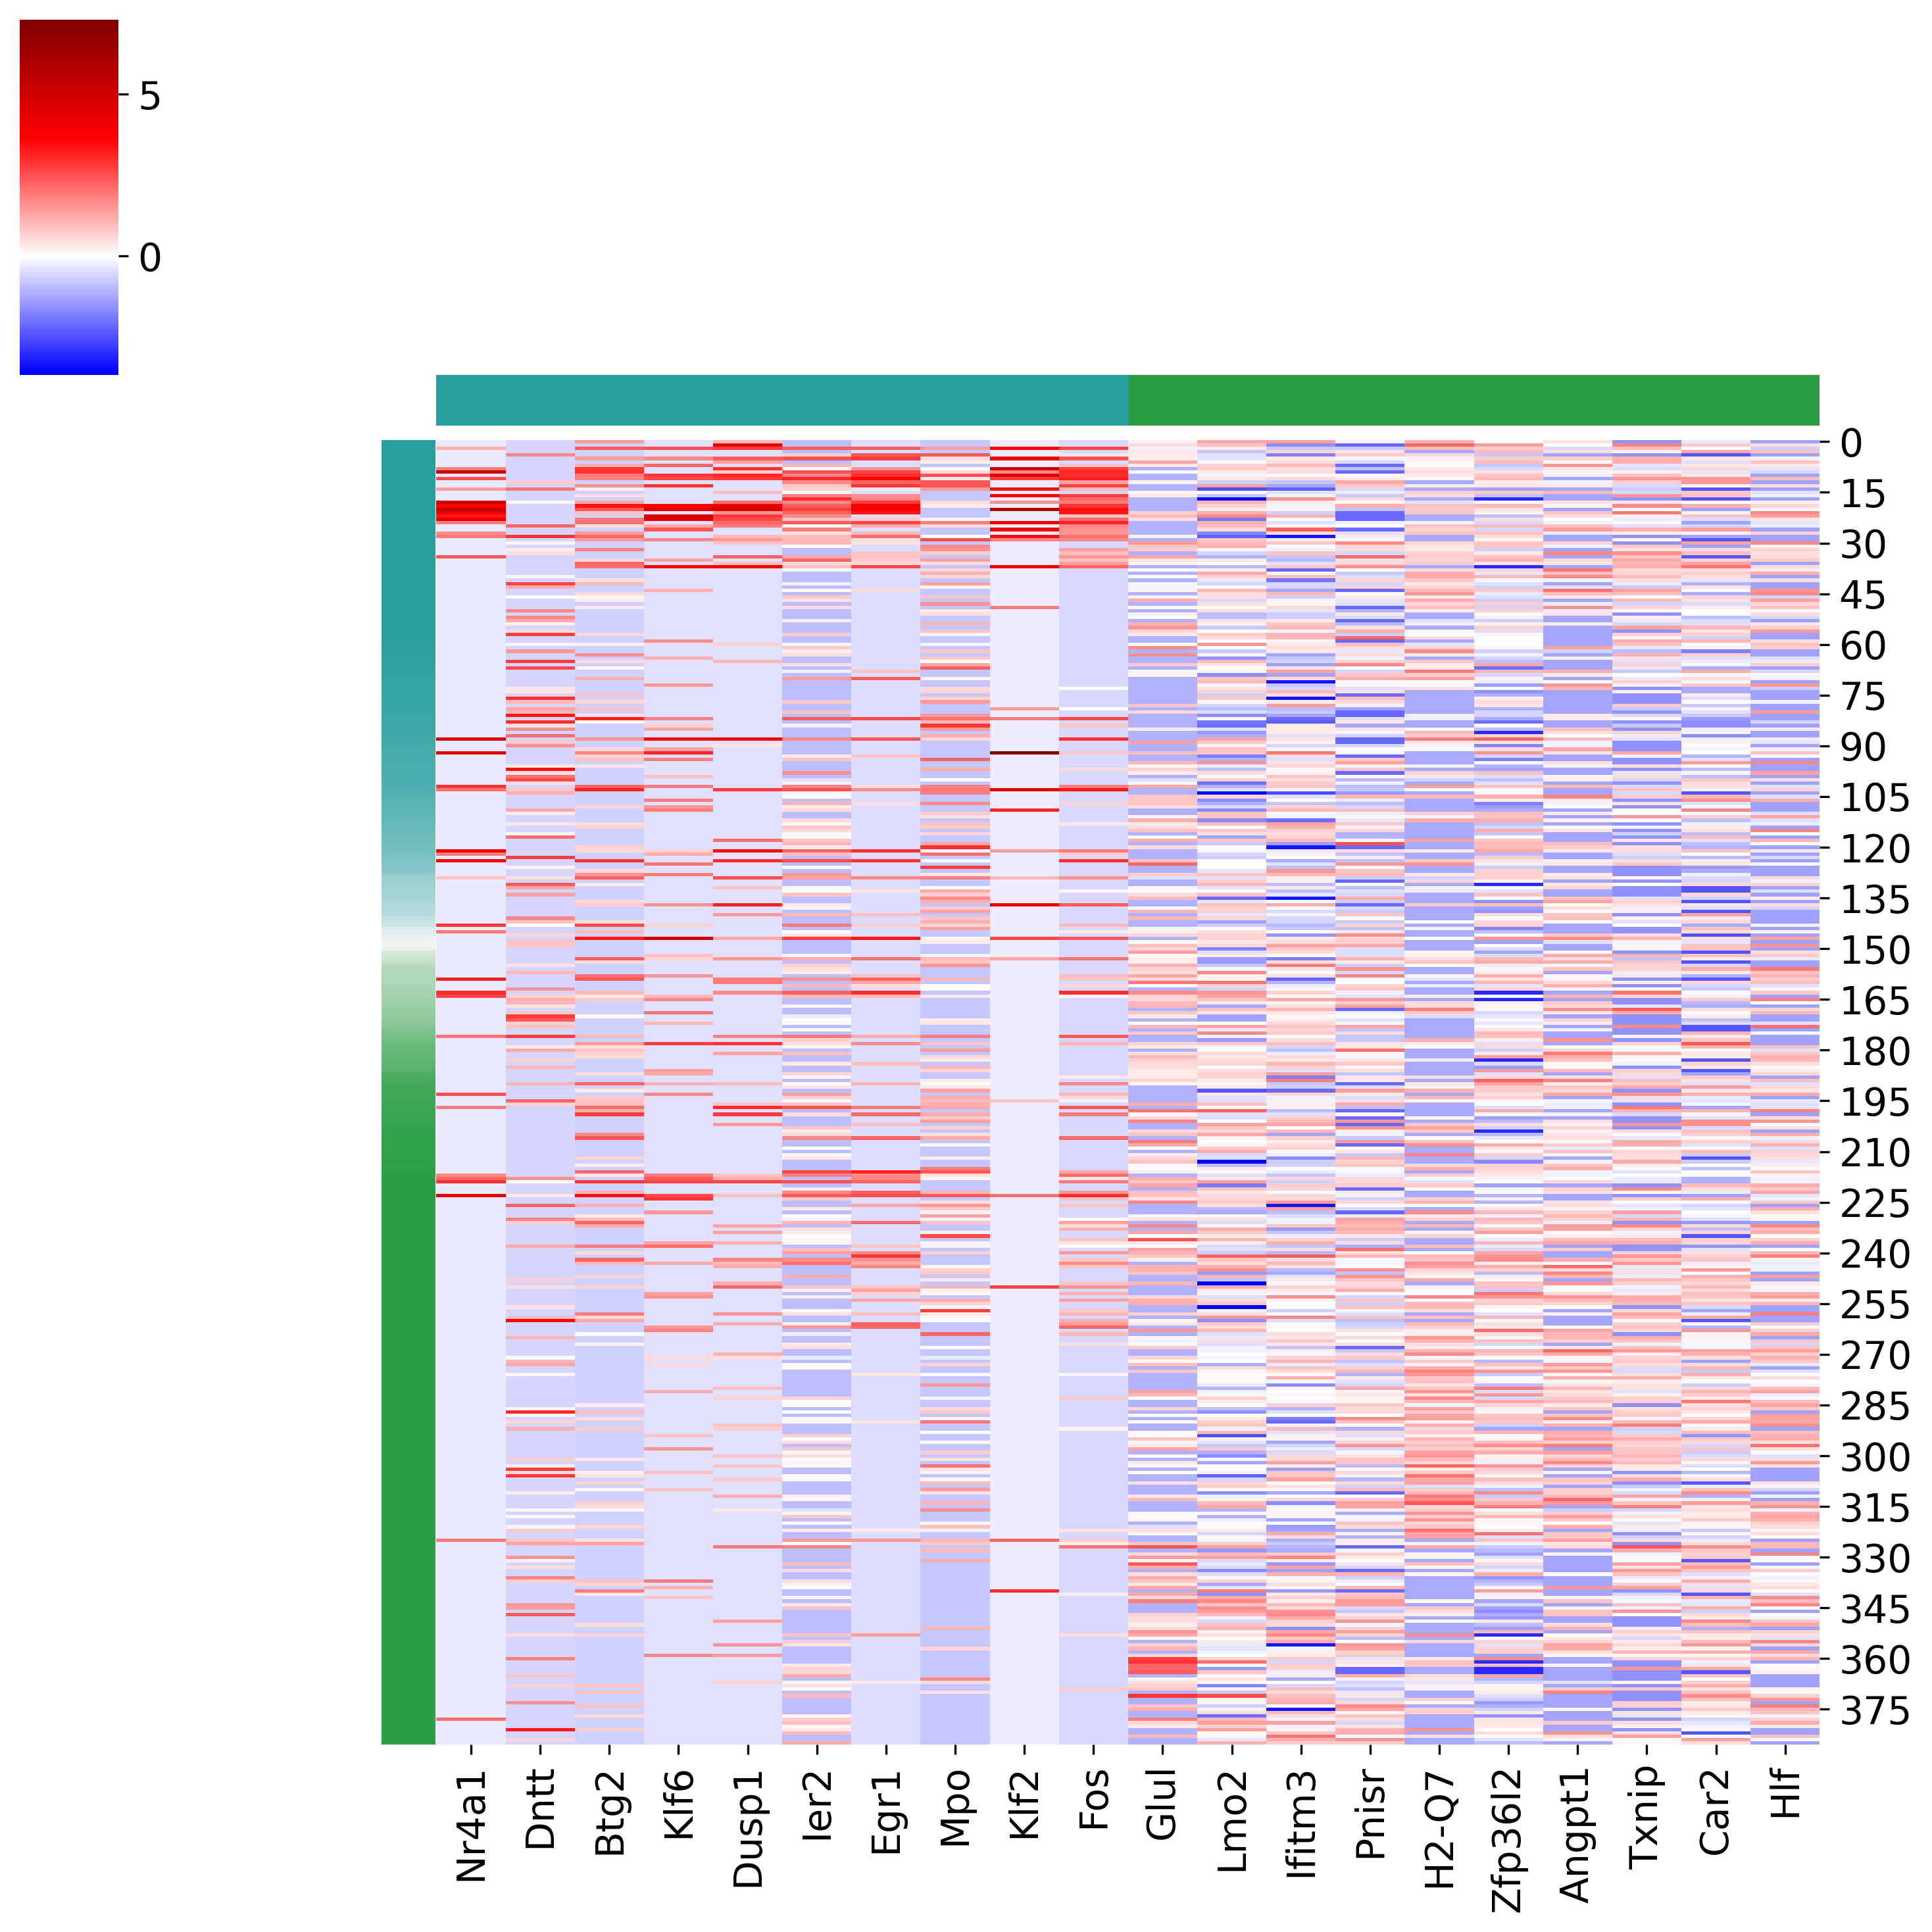

In [20]:
#adata.obs['prob']=adata.obs['prob'].astype(float)
adata2 = adata[(adata.obs['prob'])!='None']
adata2.obs['prob']=adata2.obs['prob'].astype(float)
x_indices = list(map(lambda x: x[0], sorted(enumerate(adata2.obs['prob']), key=lambda x: x[1])))
var_names = top_genes_bias.index
y_indices = list(map(lambda x: list(adata2.var.index).index(x), var_names))

expr = adata2.X[x_indices,:,][:,y_indices].toarray()
expr = pd.DataFrame(expr, columns=var_names)
cmap = make_colormap(['#289E9E','#F7F7F7','#2B9E44'])

fig=sns.clustermap(
    expr, 
    row_cluster=False, 
    col_cluster=False, 
    z_score=1, 
    
#     vmin=-2,
#     vmax=2,
    cmap='seismic', 
    col_colors=['#289E9E'] * 10 + ['#2B9E44'] * (len(var_names) - 10), 
    row_colors = list(map(lambda x: cmap(float(x) ), adata2.obs['prob'][x_indices])),
    center=0
)
#fig.savefig('/home/zhengtuo/songtao/DestinyNet/carlin_figure/heatmap.pdf')
# fig.savefig("/Users/snow/Downloads/20230914_LT_Pseudotime_Biddy_prob_gene_exp/heatmap.png")

In [395]:
adata3_GT

AnnData object with n_obs × n_vars = 777 × 20863
    obs: 'sample_name', 'leiden', 'reannotation', 'preference', 'preference_HSC', 'preference_MPP', 'index', 'fate_pred', 'prob'
    uns: 'fate_pred_colors', 'neighbors', 'preference_HSC_colors', 'reannotation_colors', 'umap', 'rank_genes_groups'
    obsm: 'X_emb', 'X_emb_old', 'X_pca', 'X_pca_sct', 'X_umap', 'X_umap_sct', 'geneEnc', 'genemap'
    obsp: 'connectivities', 'distances'

In [389]:
import pandas as pd


genes_df = pd.DataFrame(adata3_GT.uns['rank_genes_groups']['names'])

GT_10_genes_group_0 = genes_df.iloc[:10, 0]
GT_10_genes_group_1 = genes_df.iloc[:10, 1]

GT_20_genes = GT_10_genes_group_0.append(GT_10_genes_group_1)

genes_index = pd.Index(GT_20_genes)


/tmp/ipykernel_97488/922251399.py:11: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  GT_20_genes = GT_10_genes_group_0.append(GT_10_genes_group_1)


In [390]:
genes_index

Index(['mt-Co3', 'H2-Q7', 'H2-Aa', 'Rps25', 'Rpl30', 'Rpl34', 'Rpl37a',
       'Rpl35a', 'Hist1h4d', 'Rpl37', 'Rplp0', 'Rps3a1', 'Gapdh', 'Hspa8',
       'Cd48', 'Ubald2', 'Gm8797', 'Ccl9', 'Rpl8', 'Ifitm1'],
      dtype='object')

In [ ]:
from scipy.stats import zscore

selected_data = adata2[adata2.obs['fate_pred'].isin(['Ery','My'])]

z_scores = zscore(selected_data.X.toarray(), axis=0)

selected_data.X = z_scores
sc.pl.heatmap(
    selected_data,
    top_genes,
    groupby='fate_pred',
    cmap='RdBu_r',
    vmin=-3,
    vmax=3
)


In [ ]:
sns.clustermap(
selected_data,
    top_genes,

)

In [8]:
import tqdm
from scanpy.neighbors import _compute_connectivities_umap

weinreb_adata_to_plot=adata2.copy()
weinreb_adata_mon =  weinreb_adata_to_plot[
        (np.array(weinreb_adata_to_plot.obs['reannotation'] == 'Ery') | 
    np.array(weinreb_adata_to_plot.obs['fate_pred'] == 'Ery') ) 
    #np.array(biddy_adata.obs['leiden'] != '9')  & np.array(biddy_adata.obs['leiden'] != '13')     
]

nn = NearestNeighbors(n_neighbors=20)
nn.fit(weinreb_adata_mon.obsm["geneEnc"][:,0,:])
D,I=nn.kneighbors(weinreb_adata_mon.obsm["geneEnc"][:,0,:])
# weinreb_adata_to_plot.uns['dE']
from scipy import spatial
II,DD=[],[]
pbar = tqdm.tqdm(total=len(weinreb_adata_mon))
idE = dE[(np.array(weinreb_adata_to_plot.obs['reannotation'] == 'Ery') | 
    np.array(weinreb_adata_to_plot.obs['fate_pred'] == 'Ery') ) ]

for i,d in zip(I,D):
    index = list(map(lambda x: spatial.distance.cosine(x-weinreb_adata_mon.obsm["X_umap"][i[0]], idE[i[0]] ) > 0, weinreb_adata_mon.obsm["X_umap"][i[1:]]))
    II.append(i[1:][index][:8])
    DD.append(d[1:][index][:8])
    pbar.update(1)
II,DD=np.vstack(II),np.vstack(DD)
import warnings
from scipy.sparse import coo_matrix
II,DD=np.vstack(II),np.vstack(DD)
Dc,Cc=_compute_connectivities_umap(II,DD,weinreb_adata_mon.shape[0],8)
Dc,Cc=_compute_connectivities_umap(I,D,weinreb_adata_mon.shape[0],8)
weinreb_adata_mon.obsp['connectivities']=Cc
weinreb_adata_mon.obsp['distances']=Dc

undiff_cells = weinreb_adata_mon[weinreb_adata_mon.obs['reannotation'] == 'Ery']
min_x_index = np.argmax(undiff_cells.obsm["X_umap"][:, 0])
root_cell_index = undiff_cells.obs.index[min_x_index]
weinreb_adata_mon.uns['iroot'] = np.where(weinreb_adata_mon.obs.index == root_cell_index)[0][0]

sc.tl.diffmap(weinreb_adata_mon)
sc.tl.dpt(weinreb_adata_mon)
weinreb_adata_mon.obs['dpt_pseudotime'] = 1-weinreb_adata_mon.obs['dpt_pseudotime']

In [9]:
fig, axes = plt.subplots(4, 1)
fig.set_size_inches(5, 10)
for i, ax in zip(['Apoe', 'Flt3','Mllt3'], axes):
    varindex = list(weinreb_adata_mon.var.index).index(i)
    indices = weinreb_adata_mon[:, varindex].X.toarray().ravel() != 0
    sns.regplot(
        x=weinreb_adata_mon.obs.loc[indices, 'dpt_pseudotime'],
        y=weinreb_adata_mon[indices].X.toarray()[:, varindex].ravel(),
        scatter_kws={
            's': 10,
            'linewidth': 0,
            'color': list(map(lambda x: plt.cm.viridis(x), weinreb_adata_mon.obs.loc[indices, 'dpt_pseudotime']))
        },
        lowess=True,
        ax=ax
    )


In [10]:
# sc.pl.umap(weinreb_adata_mon,color='dpt_pseudotime')

In [11]:
# sc.pl.umap(weinreb_adata_mon,color='reannotation')

In [19]:
from colour import Color
from matplotlib.colors import LinearSegmentedColormap
def make_colormap( colors, show_palette = False ): 
    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in colors ] )
    if show_palette:
        plt.figure( figsize = (15,3))
        plt.imshow( [list(np.arange(0, len( colors ) , 0.1)) ] , interpolation='nearest', origin='lower', cmap= color_ramp )
        plt.xticks([])
        plt.yticks([])
    return color_ramp

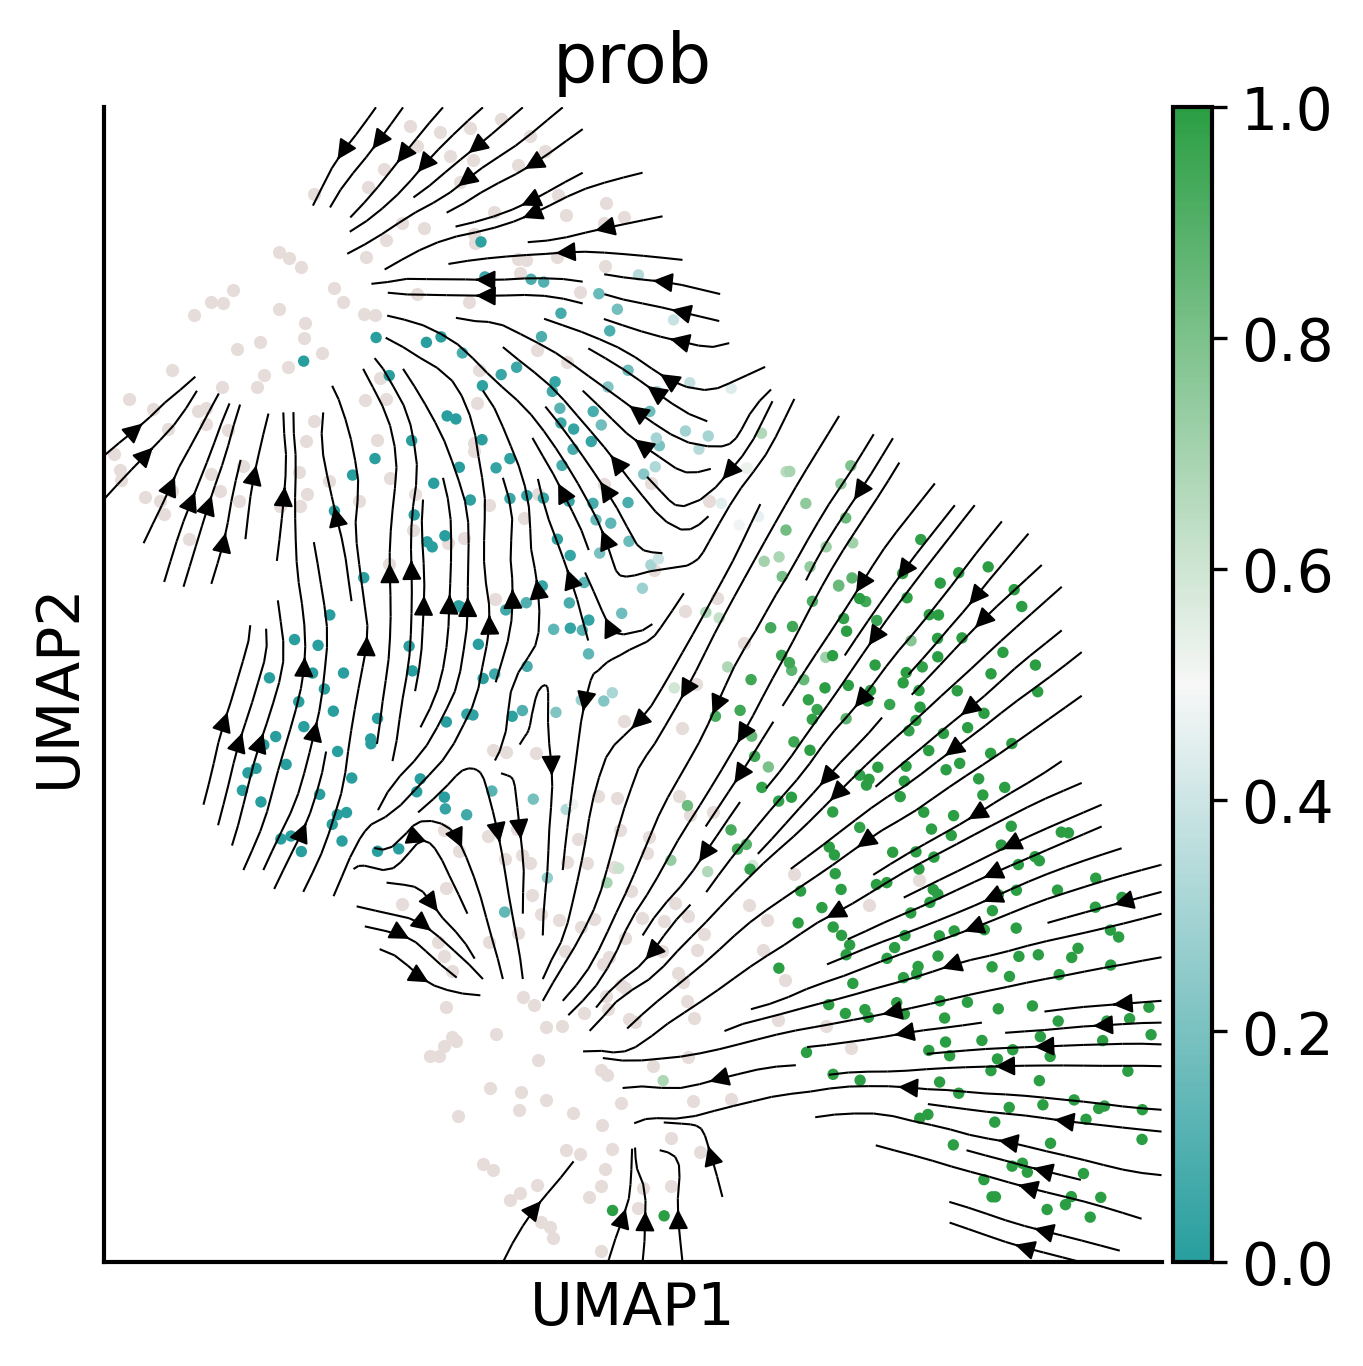

In [467]:
fig,ax=createFig()
fig.set_size_inches(5,5)
adata.obs['prob'] =  list(map(lambda x: 0 if not x or x == 'None' else float(x), adata.obs['prob']))
ax.scatter(
    adata[list(map(lambda x: x != 'HSC', adata.obs['reannotation']))].obsm["X_umap"][:,0],
    adata[list(map(lambda x: x != 'HSC', adata.obs['reannotation']))].obsm["X_umap"][:,1],
    s = 10, color='#E6DCD9', linewidth=0
)
sc.pl.umap(
    adata[list(map(lambda x: x == 'HSC', adata.obs['reannotation']))], 
    ax=ax, 
    color='prob', 
    s=30, 
    cmap=make_colormap(['#289E9E','#F7F7F7','#2B9E44']),
    show=False
)
ax.streamplot(gE[0],gE[1],gdE[0],gdE[1],**stream_kwargs)
ax.figure.savefig('/home/zhengtuo/songtao/DestinyNet/carlin_figure/flow.pdf', bbox_inches='tight') 


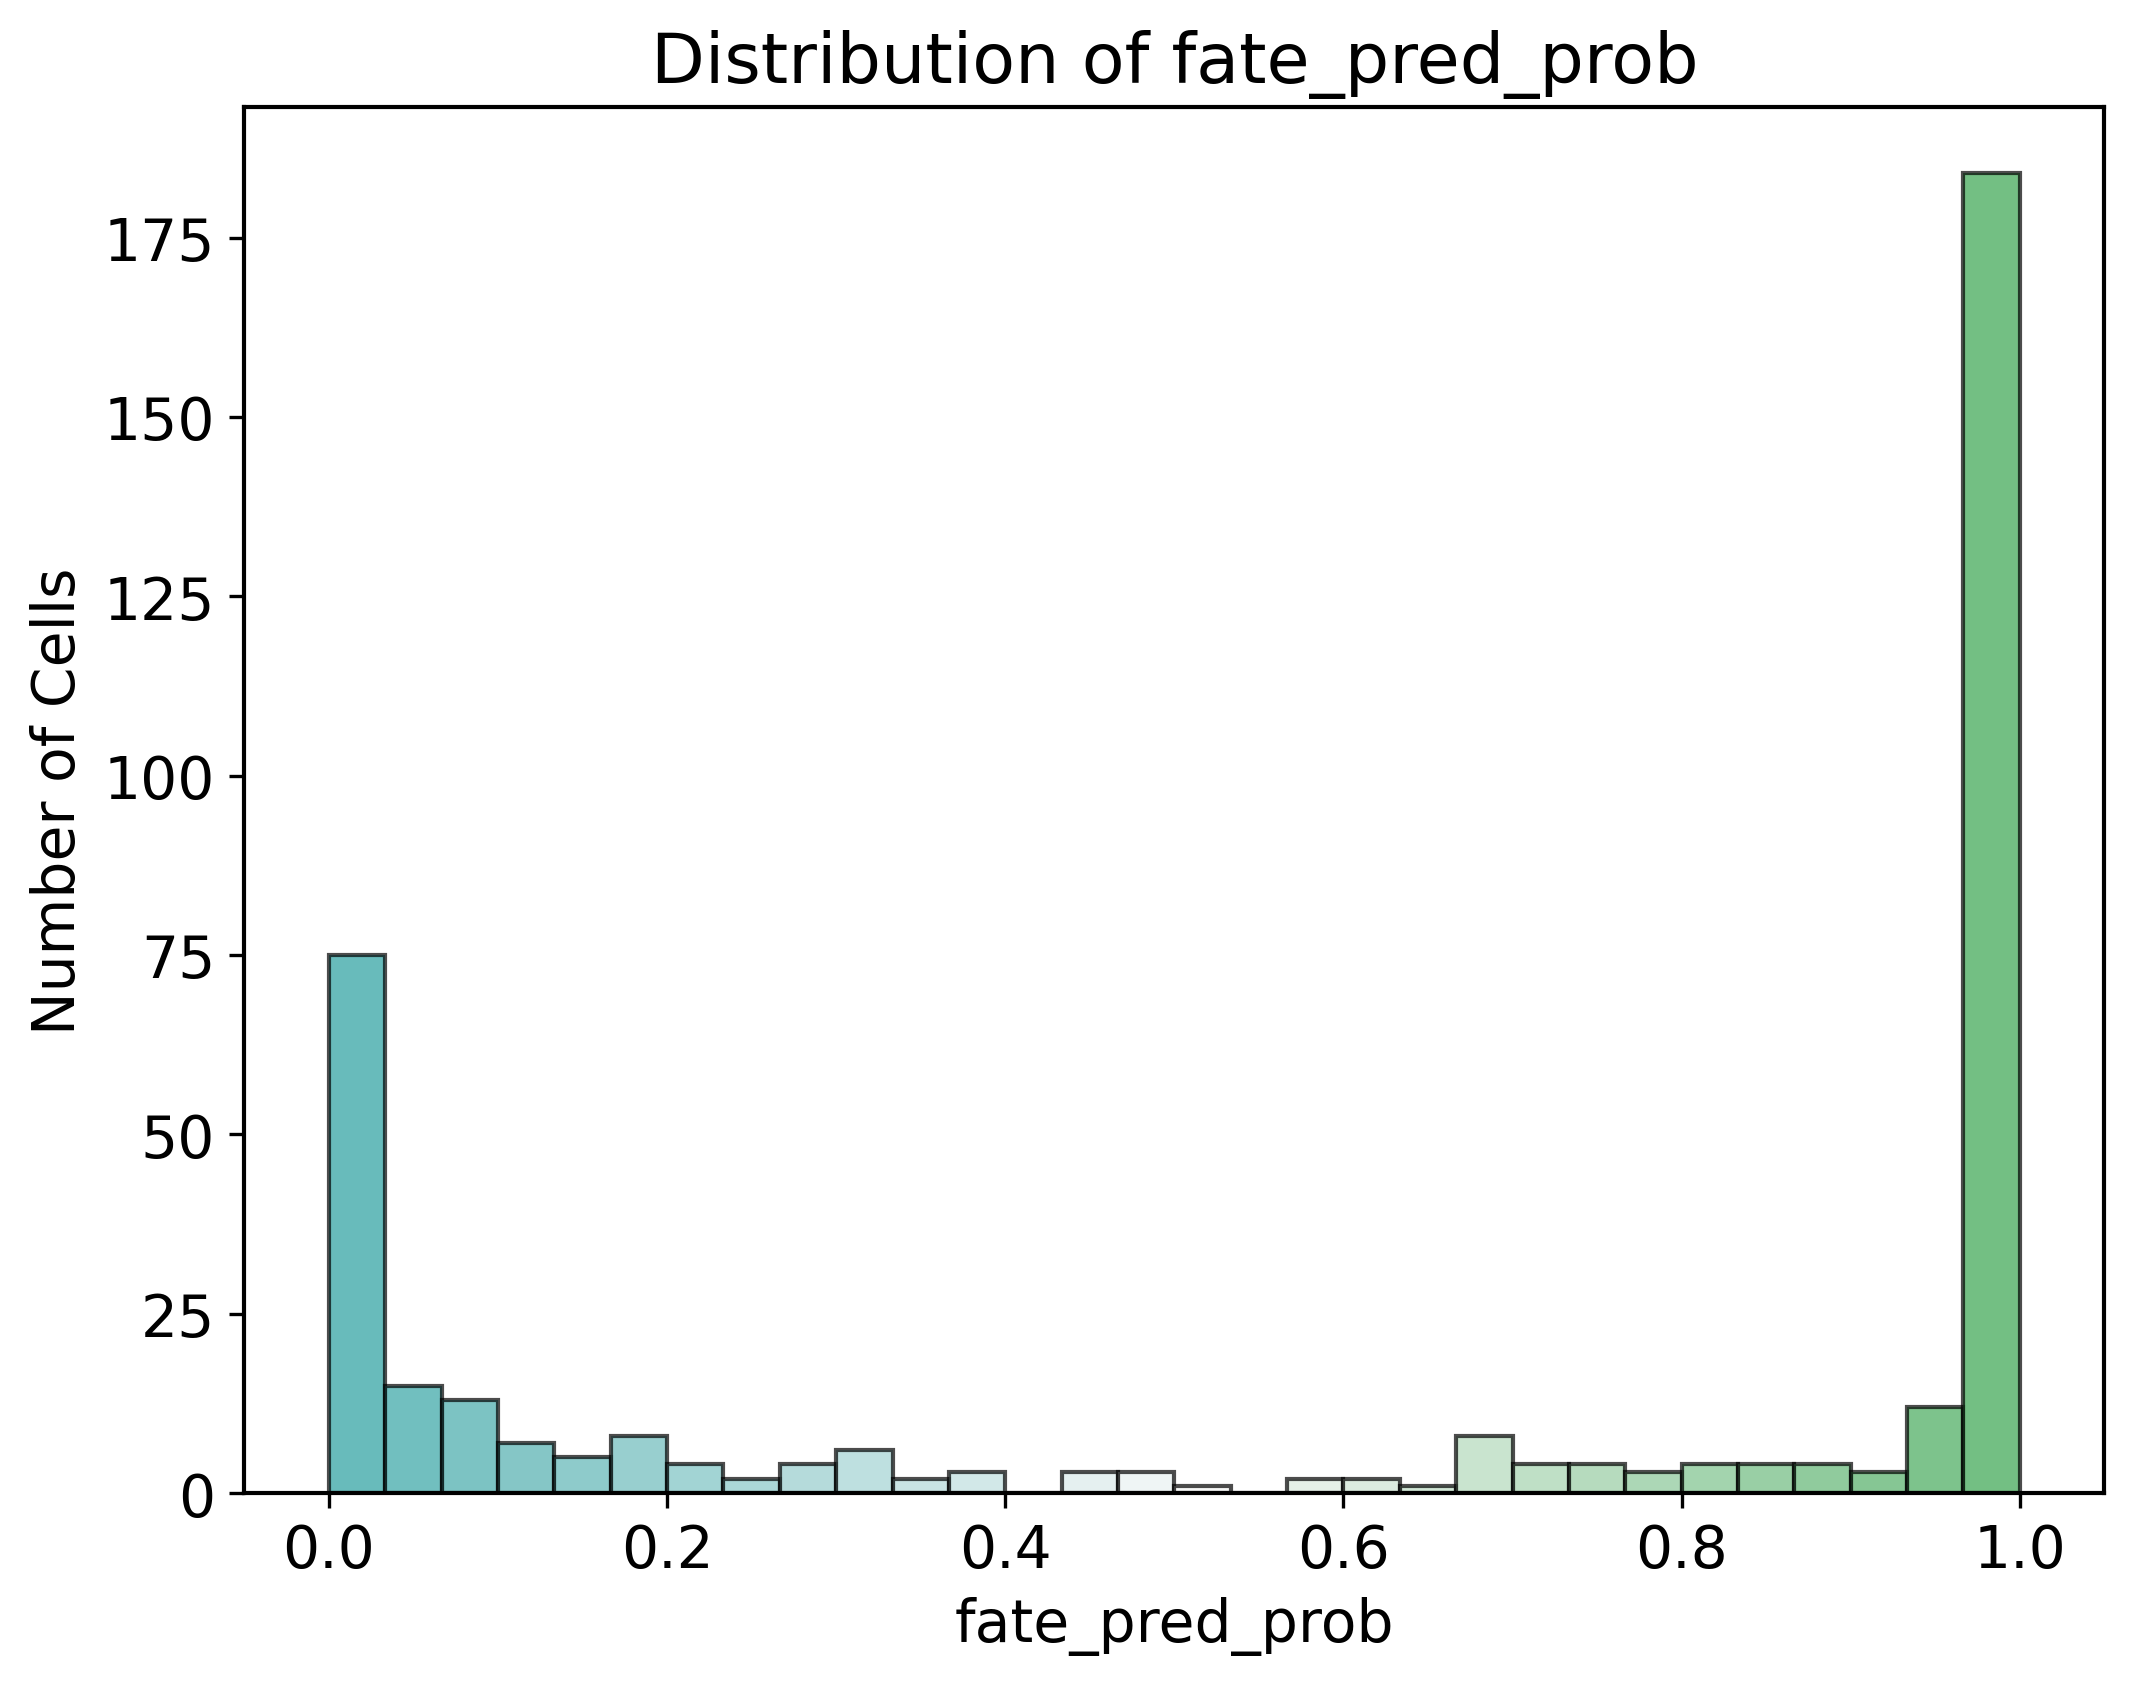

In [468]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

colormap=make_colormap(['#289E9E','#F7F7F7','#2B9E44'])
data = adata[adata.obs['reannotation']=='HSC'].obs['prob']

plt.figure(figsize=(8, 6))
n, bins, patches = plt.hist(data, bins=30, edgecolor='black', alpha=0.7)

norm = plt.Normalize(data.min(), data.max())

for thisbin, thispatch in zip(bins, patches):
    color = colormap(norm(thisbin))
    thispatch.set_facecolor(color)

plt.title("Distribution of fate_pred_prob")
plt.xlabel("fate_pred_prob")
plt.ylabel("Number of Cells")
plt.savefig("/home/zhengtuo/songtao/DestinyNet/carlin_figure/hisgram_carlin.pdf", bbox_inches='tight')

plt.show()


In [81]:
top_genes

Index(['Mllt3', 'Hnrnpa1', 'Eif5a', 'Scaper', 'Tmem71', 'Casc3', 'Hacd4',
       'Prnp', 'Neurl3', 'Zscan2', 'Nkx2-3', 'Psmb4', 'Jun', 'Ssb', 'Psmb8',
       'Ifi27', 'Flt3', 'Ctsl', 'H2-K1', 'Pde4b'],
      dtype='object')